In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def sortcery_loss(etab, E_idx, data):
    ''' Compute the mean squared error between the etab's predicted energies for peptide-protein complexes and experimental energies derived from SORTCERY.
    '''
    n_batch, L, k, _ = etab.shape
    assert n_batch == 1, "batch size should be set to 1 for fine-tuning with SORTCERY"

    etab = etab[0].unsqueeze(-1).view(L, k, 20, 20)
    
    E_idx = E_idx[0]
    ref_seqs = data["seqs"][0]
    x_mask = data["x_mask"][0]
    peptide_seqs = data["sortcery_seqs"][0]
    ref_energies = data["sortcery_nrgs"][0]

    # X is encoded as 20 so lets just add an extra row/col of zeros
    pad = (0, 1, 0, 1)
    etab = F.pad(etab, pad, "constant", 0) # L x 30 x 21 x 21
    # print(etab.shape)

    peptide_shape = peptide_seqs.shape # n, c; c is the length of the chain
    etab = etab.unsqueeze(0).expand(peptide_shape[0], -1, -1, -1, -1) # n x L x 30 x 21 x 21
    # print(etab.shape)

    protein_seq = ref_seqs[:-peptide_shape[1]] # (L - c), remove the native peptide to obtain only the protein sequences, so we can replace the peptides with SORTCERY peptides
    complex_seqs = torch.cat((protein_seq.unsqueeze(0).expand(peptide_shape[0], -1), peptide_seqs), dim=1) # n x L
    # print(complex_seqs.shape)
    # print(complex_seqs)

    # identity of all residues
    seq_residues = complex_seqs.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, k, 21).unsqueeze(-1) # n x L x 30 x 21 x 1
    E_neighbors = torch.gather(etab, -1, seq_residues).squeeze(-1) # n x L x 30 x 21, gather etabs for each known residue in seqs
    # print(E_neighbors.shape)

    # identity of all kNN
    E_idx_expanded = E_idx.unsqueeze(0).expand(peptide_shape[0], -1, -1)
    E_aa = torch.gather(complex_seqs.unsqueeze(-1).expand(-1, -1, k), 1, E_idx_expanded).unsqueeze(-1) # n x L x 30 x 1
    E_seqs = torch.gather(E_neighbors, -1, E_aa).squeeze(-1) # n x L x 30
    # print(E_idx[:5])
    # print(E_seqs[:5])

    # halve the energies of all bidirectional edges to avoid double counting
    adj_matrix = torch.zeros((L,L), device=etab.device)
    residueNums = E_idx[:,0].unsqueeze(-1).expand(-1, k)
    edgeIndices = torch.cat((residueNums.reshape(-1,1), E_idx.reshape(-1,1)), dim=-1)
    adj_matrix[edgeIndices[:,0], edgeIndices[:,1]] = 1
    adj_matrix = adj_matrix + adj_matrix.t() # add the adjacency matrix to its transpose; bidirectional edges will have value 2
    bidir_mask = torch.gather(adj_matrix, -1, E_idx)
    bidir_mask[:,0] = 1 # self edges will be double counted, so we reset; then we take the reciprocal so that bidirectional edges have value 1/2 in the mask
    bidir_mask = (1/bidir_mask).unsqueeze(0).expand(peptide_shape[0], -1, -1) # n x L x 30
    # print(bidir_mask.shape)
    # print(bidir_mask[0])

    # masks for residues with identity X (isnt_x_aa) and unmodeled residues (x_mask)
    isnt_x_aa = (complex_seqs != 20).float().to(etab.device) # n x L
    x_mask = x_mask.expand(peptide_shape[0], -1).unsqueeze(-1) # n x L x 1
    isnt_x_aa = isnt_x_aa.unsqueeze(-1) # n x L x 1
    full_mask = x_mask * isnt_x_aa # n x L x 1
    # print(full_mask)

    # mask to only include peptide self energies and peptide-protein pair energies, no protein-only energies
    protein_len = torch.numel(protein_seq)
    peptide_mask = torch.where(E_idx < protein_len, torch.zeros(1, device=etab.device), torch.ones(1, device=etab.device)) # zero out any interactions with the protein
    peptide_mask[protein_len:, :] = 1 # put back all protein-peptide interactions
    # print(peptide_mask)

    E_seqs *= full_mask * bidir_mask * peptide_mask # n x L x 30

    # compute predicted energy for each sequence
    predicted_E = E_seqs.sum(dim=(-2,-1)) # n, sum across all pairs for all L residues

    # normalize values around 0 for pearson correlation calculation
    norm_pred = predicted_E - torch.mean(predicted_E) # n
    norm_ref = ref_energies - torch.mean(ref_energies) # n
    # print(norm_pred)
    # print(norm_ref)

    # pearson = torch.sum(norm_pred * norm_ref) / (torch.sqrt(torch.sum(norm_pred**2)) * torch.sqrt(torch.sum(norm_ref**2)))
    # # print(np.corrcoef(norm_pred,norm_ref)[0][1])
    # return -pearson, 1 # scalar; negate, since we want to minimize our loss function
    return np.corrcoef(norm_pred,norm_ref)[0][1]

In [4]:
pdbs = """B2CL1_HUMAN_2P1L_A_holo
B2CL1_HUMAN_2PON_B_holo
B2CL1_HUMAN_4CIN_A_holo
B2CL1_HUMAN_3IO8_A_holo
B2CL1_HUMAN_4QVE_A_holo
B2CL1_HUMAN_2P1L_C_holo
B2CL1_HUMAN_2P1L_E_holo
B2CL1_HUMAN_3PL7_A_holo
B2CL1_HUMAN_2M04_A_holo
B2CL1_HUMAN_2P1L_G_holo
B2CL1_HUMAN_4QVF_A_holo
B2CL1_HUMAN_1G5J_A_holo
B2CL1_HUMAN_4HNJ_A_holo
B2CL1_HUMAN_5FMK_A_holo
B2CL1_HUMAN_3FDL_A_holo
B2LA1_HUMAN_5UUL_A_holo
B2LA1_HUMAN_5UUP_A_holo
B2LA1_HUMAN_3MQP_A_holo
B2LA1_HUMAN_5UUK_A_holo
B2LA1_HUMAN_4ZEQ_A_holo
B2LA1_HUMAN_2VM6_A_holo
MCL1_HUMAN_5C6H_M_holo
MCL1_HUMAN_3KJ2_A_holo
MCL1_HUMAN_5C6H_C_holo
MCL1_HUMAN_3KZ0_A_holo
MCL1_HUMAN_5C6H_G_holo
MCL1_HUMAN_2NL9_A_holo
MCL1_HUMAN_5C6H_Q_holo
MCL1_HUMAN_3D7V_A_holo
MCL1_HUMAN_3IO9_A_holo
MCL1_HUMAN_3KZ0_B_holo
MCL1_HUMAN_5C6H_K_holo
MCL1_HUMAN_3PK1_C_holo
MCL1_HUMAN_3KJ0_A_holo
MCL1_HUMAN_2KBW_A_holo
MCL1_HUMAN_5UUM_A_holo
MCL1_HUMAN_5C6H_O_holo
MCL1_HUMAN_2PQK_A_holo
MCL1_HUMAN_5C6H_A_holo
MCL1_HUMAN_5C6H_U_holo
MCL1_HUMAN_5C6H_E_holo
MCL1_HUMAN_3PK1_A_holo
MCL1_HUMAN_5C6H_W_holo
MCL1_HUMAN_5UUM_B_holo
MCL1_HUMAN_5C6H_I_holo
MCL1_HUMAN_3KJ1_A_holo
MCL1_HUMAN_5C3F_A_holo""".split("\n")
pdbs = sorted(pdbs)
print(len(pdbs))

47


In [13]:
# using E_idx, etab, and data variables saved from the model during evaluation of these structures
# testing whether the sortcery_loss function above correctly computes the Pearson correlation

for pdb in pdbs:
    E_idx = torch.load(f"../../bcl2_tensors_tic1_retry/{pdb}_E_idx.pt", map_location=torch.device('cpu'))
    etab = torch.load(f"../../bcl2_tensors_tic1_retry/{pdb}_etab.pt", map_location=torch.device('cpu'))
    data = torch.load(f"../../bcl2_tensors_tic1_retry/{pdb}_data.pt", map_location=torch.device('cpu'))
    print(pdb, sortcery_loss(etab, E_idx, data))

B2CL1_HUMAN_1G5J_A_holo 0.3106795461091124
B2CL1_HUMAN_2M04_A_holo 0.16438672863162465
B2CL1_HUMAN_2P1L_A_holo 0.18705761392808182
B2CL1_HUMAN_2P1L_C_holo 0.13414172565093724
B2CL1_HUMAN_2P1L_E_holo 0.08497651916188698
B2CL1_HUMAN_2P1L_G_holo 0.14594114672073155
B2CL1_HUMAN_2PON_B_holo 0.10142299299595525
B2CL1_HUMAN_3FDL_A_holo 0.4235461309013784
B2CL1_HUMAN_3IO8_A_holo 0.30196727564311143
B2CL1_HUMAN_3PL7_A_holo 0.12191343897623906
B2CL1_HUMAN_4CIN_A_holo 0.08991361523603318
B2CL1_HUMAN_4HNJ_A_holo 0.2869907296047085
B2CL1_HUMAN_4QVE_A_holo 0.16551924034686086
B2CL1_HUMAN_4QVF_A_holo 0.11506304231734796
B2CL1_HUMAN_5FMK_A_holo 0.018657234745695552
B2LA1_HUMAN_2VM6_A_holo 0.419737039372642
B2LA1_HUMAN_3MQP_A_holo 0.38374772389735934
B2LA1_HUMAN_4ZEQ_A_holo 0.45401837075332296
B2LA1_HUMAN_5UUK_A_holo 0.20359509624677374
B2LA1_HUMAN_5UUL_A_holo 0.2197454598909855
B2LA1_HUMAN_5UUP_A_holo 0.44522270968179395
MCL1_HUMAN_2KBW_A_holo 0.34068377866727134
MCL1_HUMAN_2NL9_A_holo 0.4781022052807

In [7]:
pdb = sorted(pdbs)[0]
E_idx = torch.load(f"../../bcl2_tensors_tic1_retry/{pdb}_E_idx.pt", map_location=torch.device('cpu'))
etab = torch.load(f"../../bcl2_tensors_tic1_retry/{pdb}_etab.pt", map_location=torch.device('cpu'))
data = torch.load(f"../../bcl2_tensors_tic1_retry/{pdb}_data.pt", map_location=torch.device('cpu'))

torch.set_printoptions(profile="full")
print(pdb, sortcery_loss(etab, E_idx, data))
torch.set_printoptions(profile="default")

tensor([[  0,   1,   2,   3,   4, 134, 147,   5, 146, 133, 138,  42, 142, 141,
         130, 148, 131,   6,   7,  41, 135, 137, 139,  45, 132,  36,  35, 145,
           8, 140],
        [  1,   2,   0,   4,   3,   5, 134, 130, 131, 133,   6,   7, 138, 132,
         135, 147,   8, 127,  42, 129, 137, 141, 146, 128,   9, 136, 142, 126,
          45, 148],
        [  2,   3,   1,   0,   5,   4,   6,   7,  42,  35, 130,  34, 134,  36,
         131,   8,   9, 133,  41, 147, 127,  43,  45,  37,  46,  10,  40, 129,
         132, 126],
        [  3,   4,   2,  42,   1,   5,   6,   0,   7,  45,  41,  43,  46, 147,
           8,  34,  35, 130,  36,   9,  40, 148,  10,  44, 133, 134, 131, 146,
          37,  33],
        [  4,   3,   5,   7,   1,   6,   2, 130,   8,   0,  42, 133,  46,   9,
         131,  45, 147, 129, 134,  10, 127, 132,  11, 103, 126,  43,  49,  99,
          41, 128]])
tensor([[[-9.8806e-01, -1.1051e-01, -2.0326e-02,  2.0018e-03, -1.3582e-02,
          -5.3269e-03,  6.7424e-03

In [14]:
import numpy as np
computed_etab = np.load(f"../../frappier_finetune_termless_np/tic1/{pdb}.etab.npy")

In [18]:
# np.diagonal(computed_etab, axis1=-1, axis2=-2)
print(computed_etab[0][0][10][10])
print(computed_etab[1][1][15][15])
print(computed_etab[2][2][13][13])
print(computed_etab[3][3][15][15])
print(computed_etab[4][4][11][11])

# print(computed_etab[0][0][10][10])
# print(computed_etab[1][0][15][10])
# print(computed_etab[2][0][13][10])
# print(computed_etab[3][0][15][10])
# print(computed_etab[4][0][11][10])

-1.0465413331985474
-0.4887005090713501
-0.3502669930458069
0.04489654302597046
0.19437584280967712


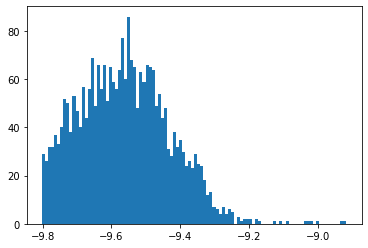

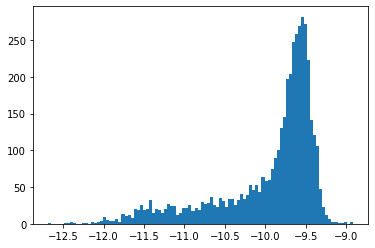

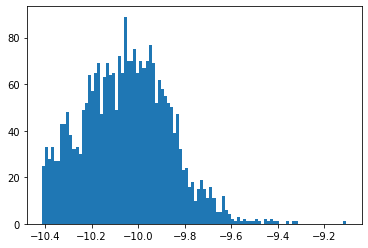

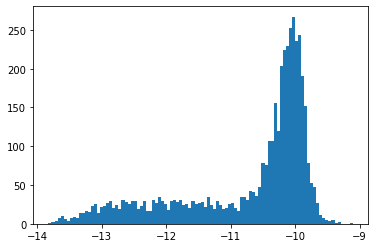

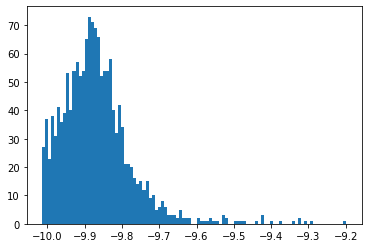

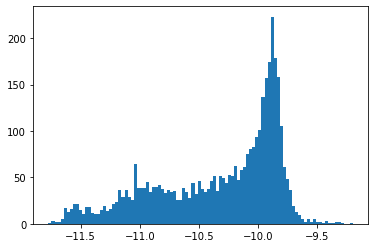

In [60]:
fractions = {'x1': 0.4, 'm1': 0.4, 'f100': 0.6}
for n in ['x1', 'm1', 'f100']:
    m1 = pd.read_pickle(f"../SORTCERY_data/{n}_energy_array.pickle")
    # print(m1['energies'])
    plt.figure()
    plt.hist(sorted(m1['energies'])[int(len(m1['energies'])*fractions[n]):], bins=100)
    plt.figure()
    plt.hist(sorted(m1['energies']), bins=100)

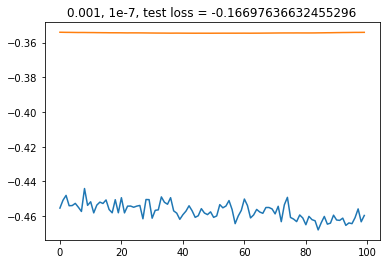

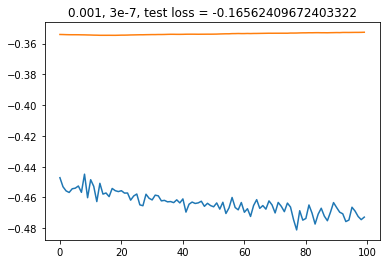

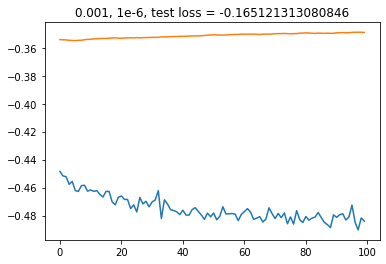

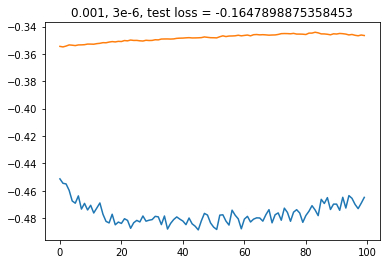

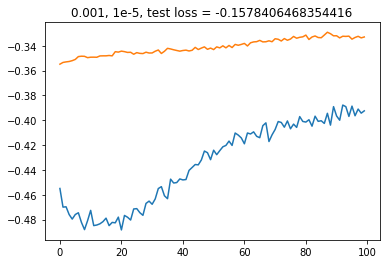

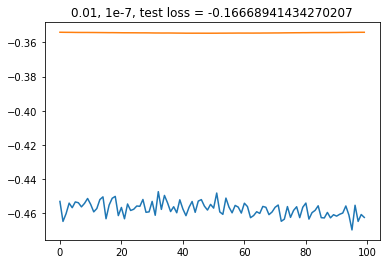

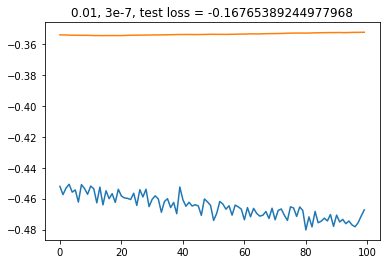

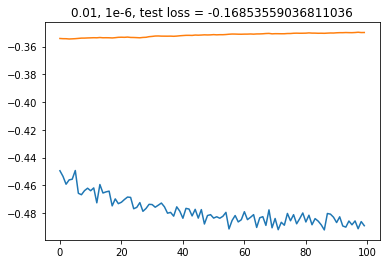

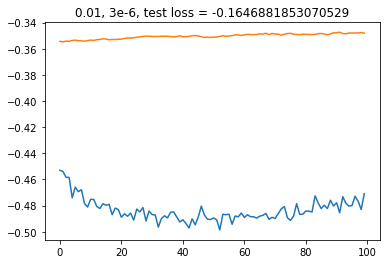

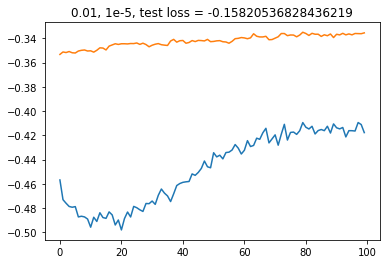

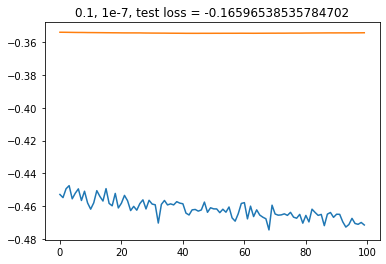

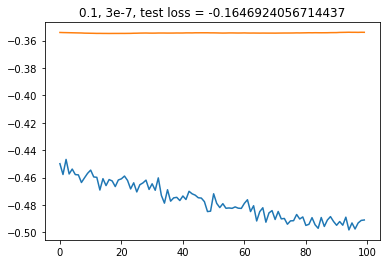

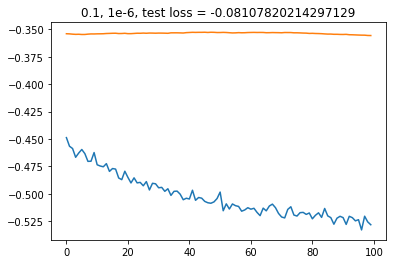

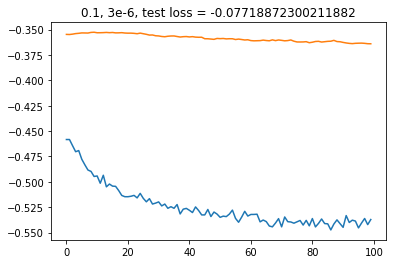

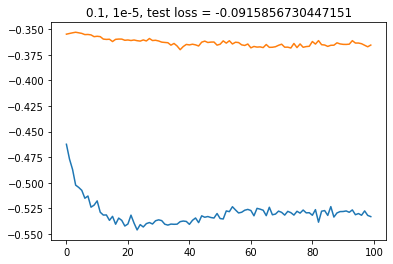

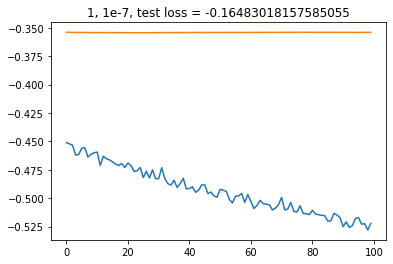

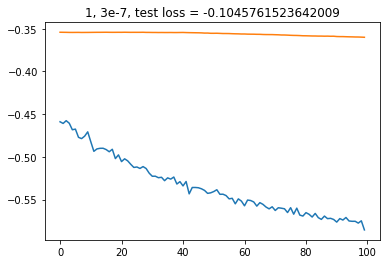

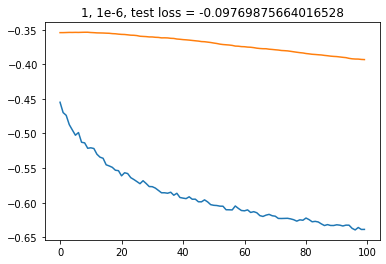

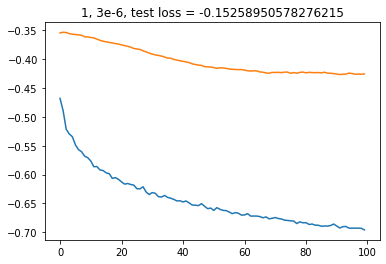

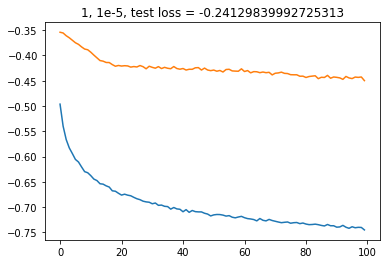

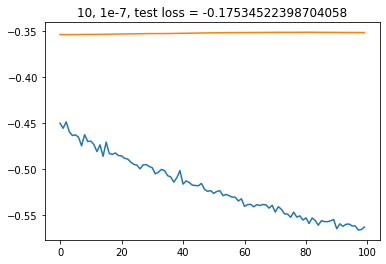

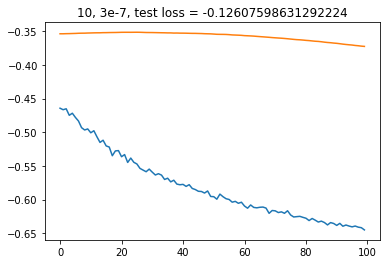

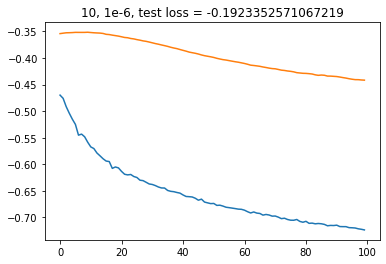

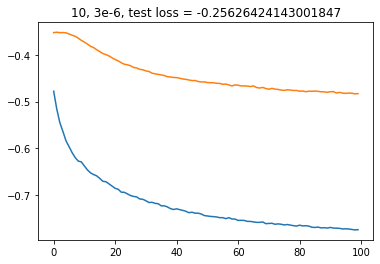

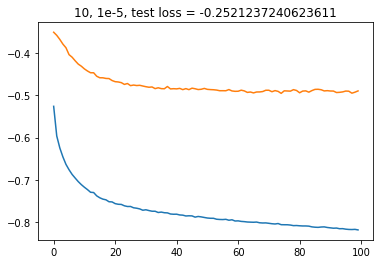

In [68]:
"""All below plots are observing the learning curves for various hyperparameter settings, checking for successful learning and convergence."""

for a in [0.001, 0.01, 0.1, 1, 10]: # this parameter is for the weight we place on the Pearson correlation compared to the nlcpl
    for b in ["1e-7", "3e-7", "1e-6", "3e-6", "1e-5"]: # this parameter is the learning rate
        f = open(f"../../finetune_results_output/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(100)]

        testloss = eval(l[-1].split("dict ")[1])['sortcery_loss']['loss']
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, test loss = {testloss}")
        plt.show()

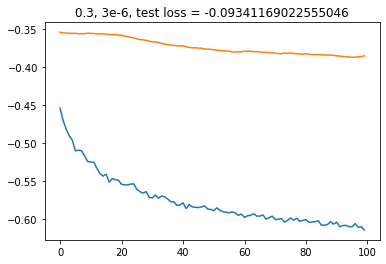

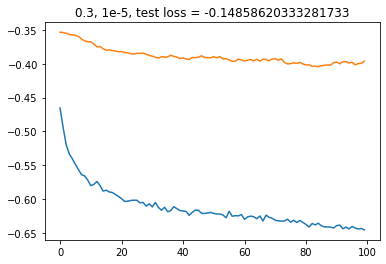

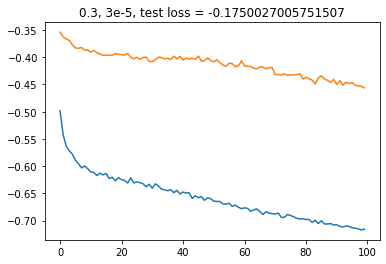

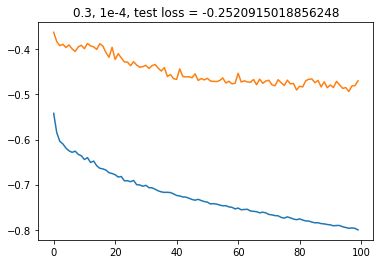

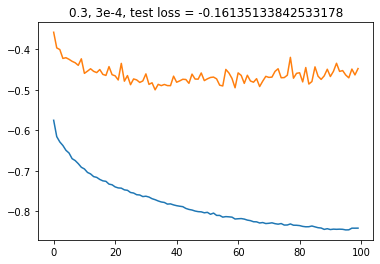

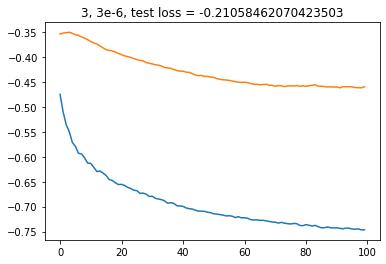

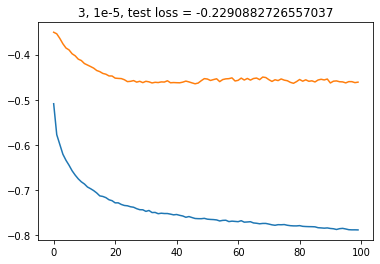

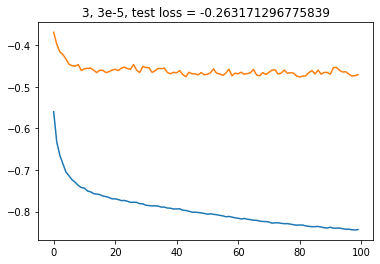

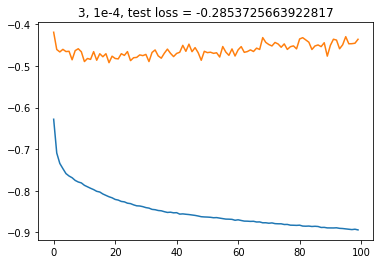

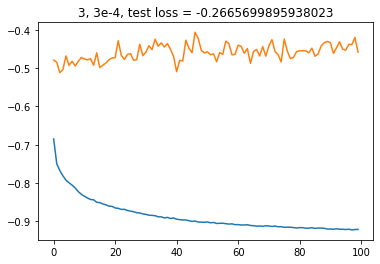

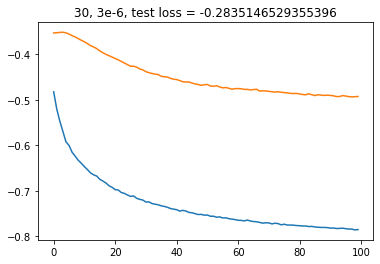

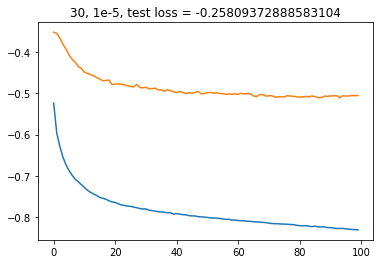

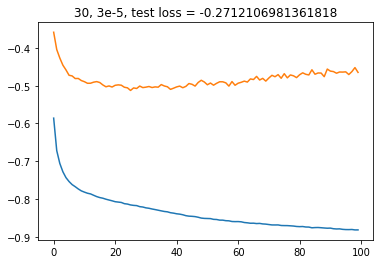

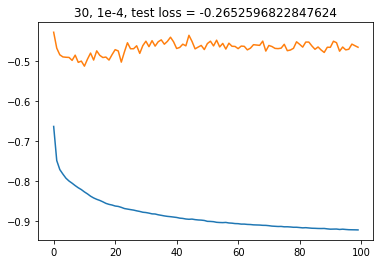

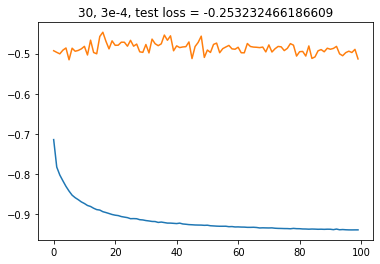

In [69]:
for a in [0.3, 3, 30]:
    for b in ["3e-6", "1e-5", "3e-5", "1e-4", "3e-4"]:
        f = open(f"../../finetune_results_output/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(100)]

        testloss = eval(l[-1].split("dict ")[1])['sortcery_loss']['loss']
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, test loss = {testloss}")
        plt.show()

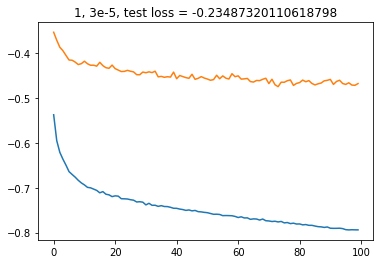

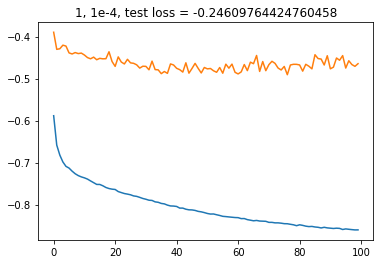

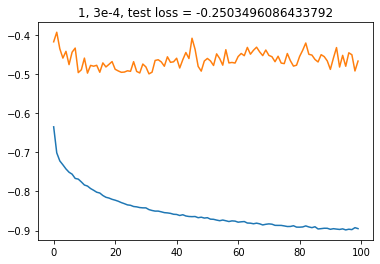

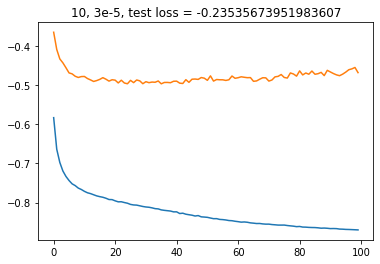

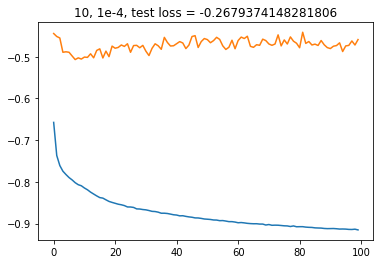

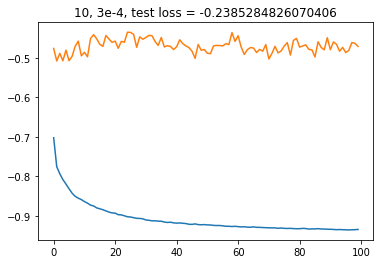

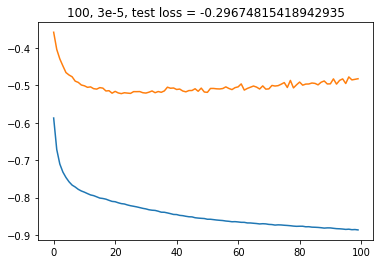

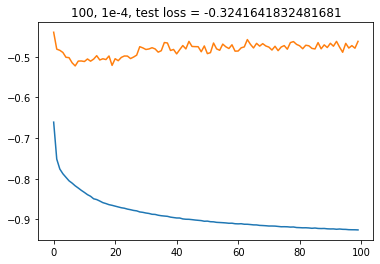

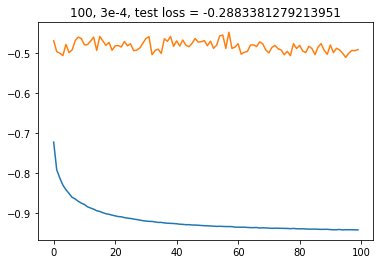

In [70]:
for a in [1, 10, 100]:
    for b in ["3e-5", "1e-4", "3e-4"]:
        f = open(f"../../finetune_results_output/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(100)]

        testloss = eval(l[-1].split("dict ")[1])['sortcery_loss']['loss']
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, test loss = {testloss}")
        plt.show()

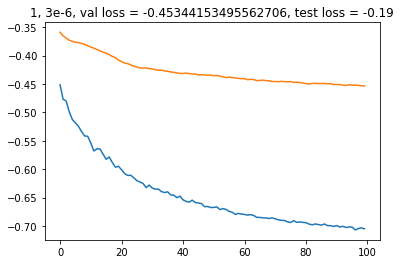

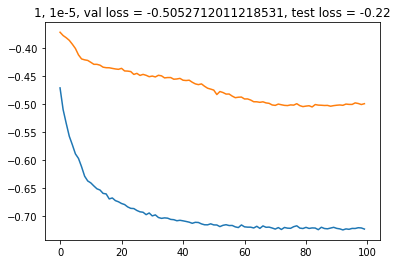

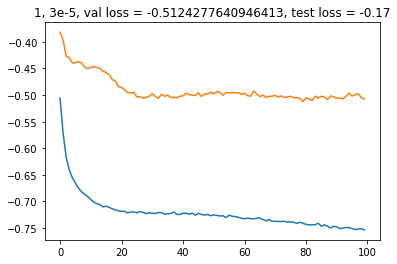

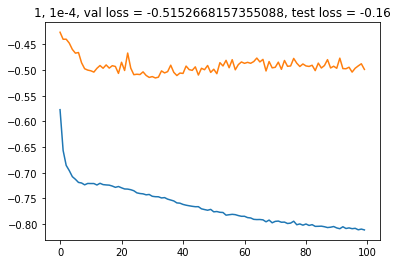

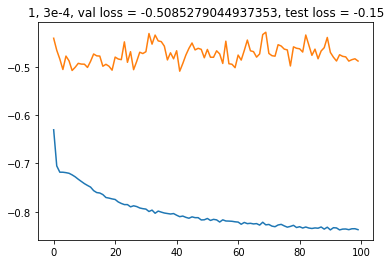

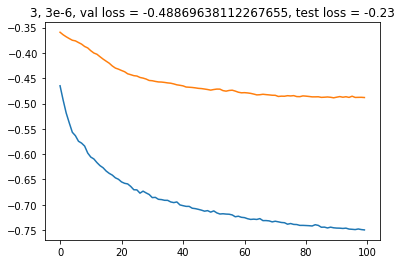

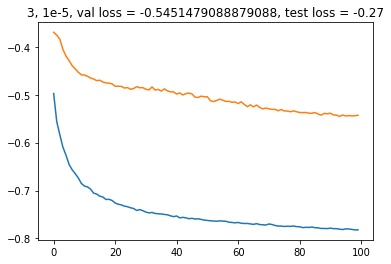

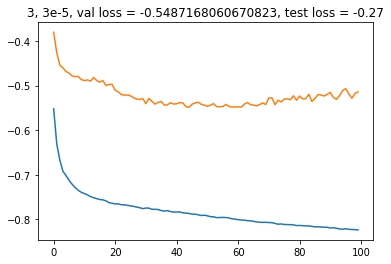

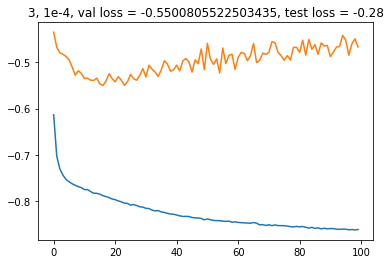

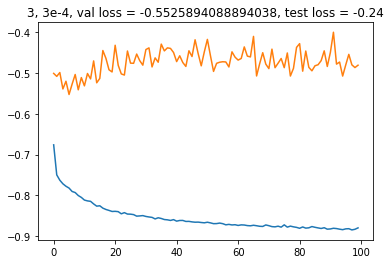

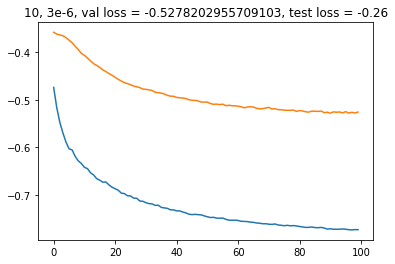

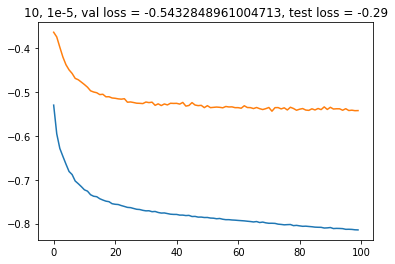

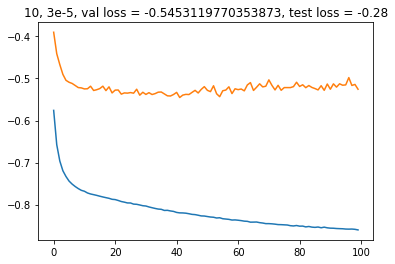

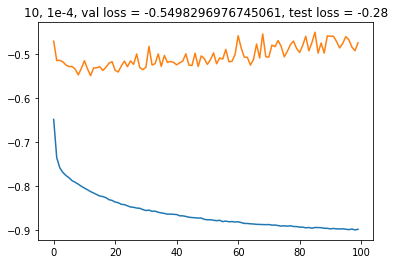

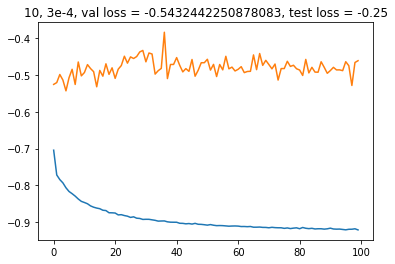

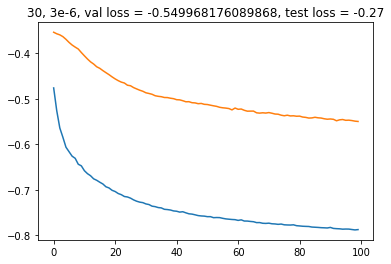

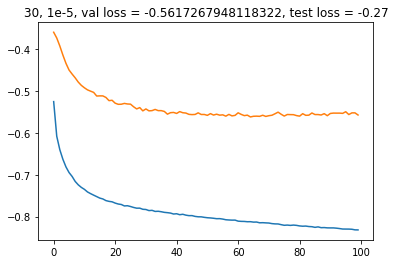

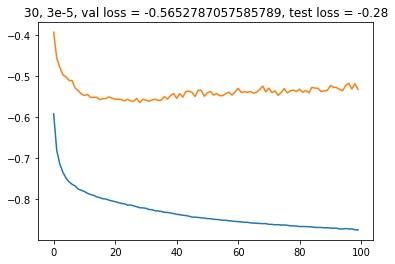

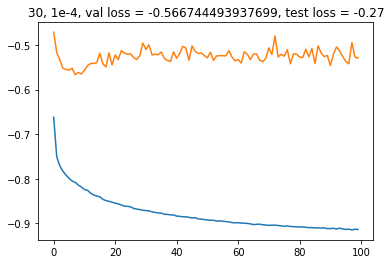

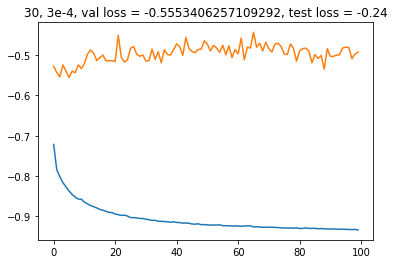

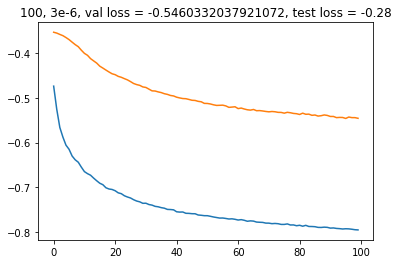

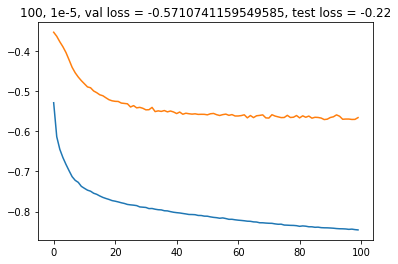

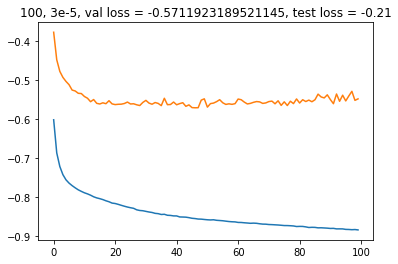

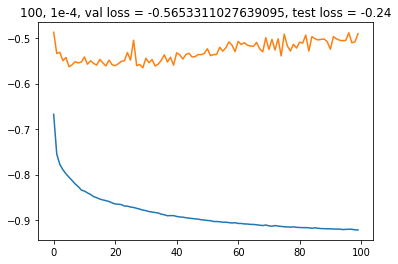

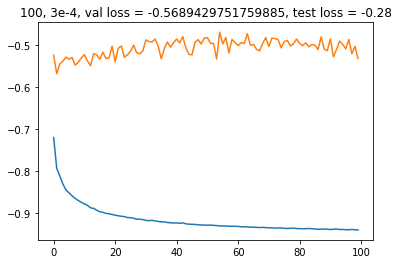

In [5]:
for a in [1, 3, 10, 30, 100]:
    for b in ["3e-6", "1e-5", "3e-5", "1e-4", "3e-4"]:
        f = open(f"../../finetune_results_output/run2/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(100)]

        testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
        valloss = min(vloss)
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
        plt.show()

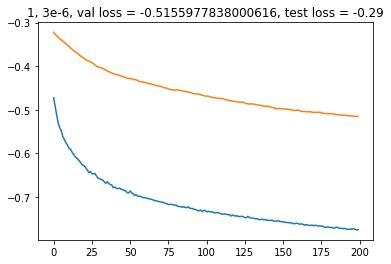

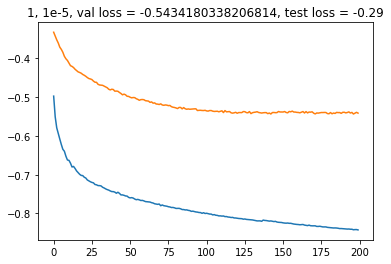

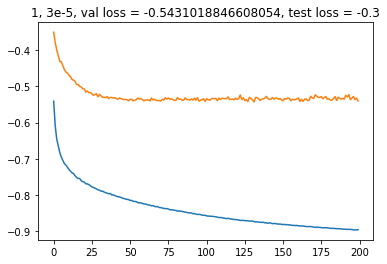

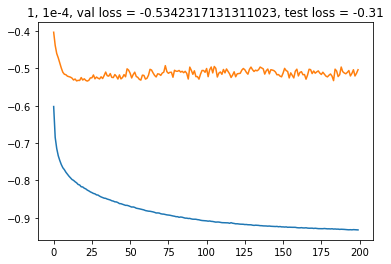

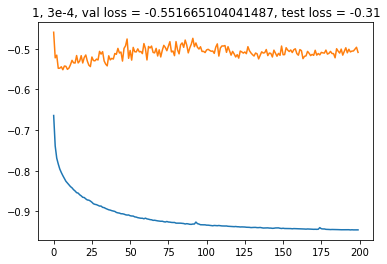

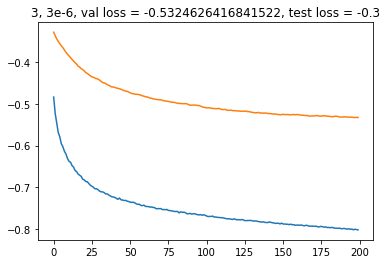

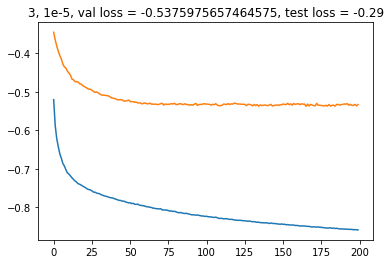

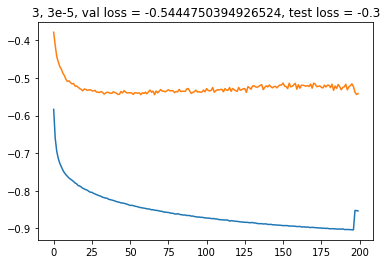

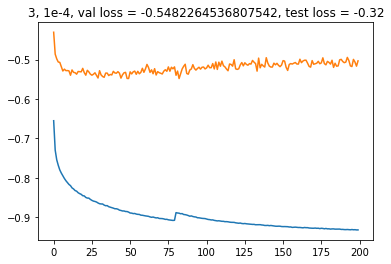

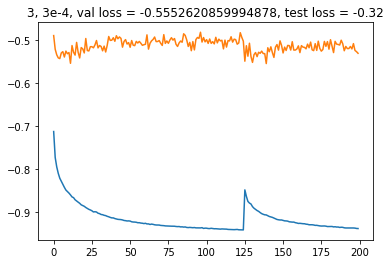

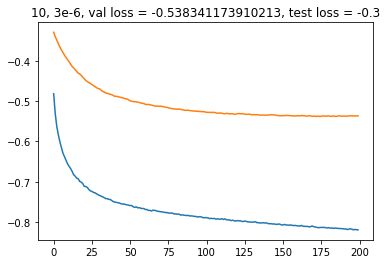

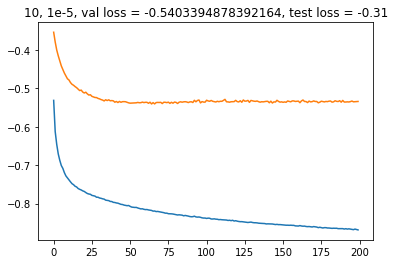

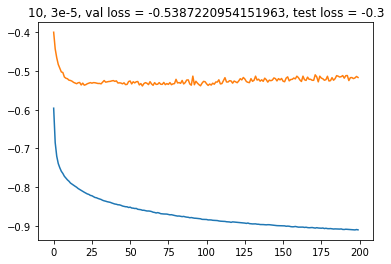

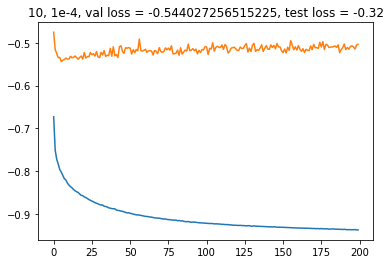

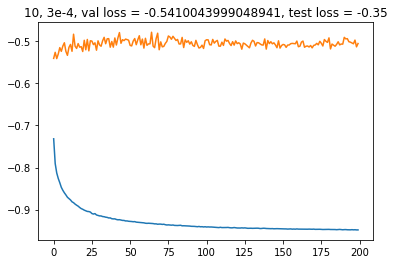

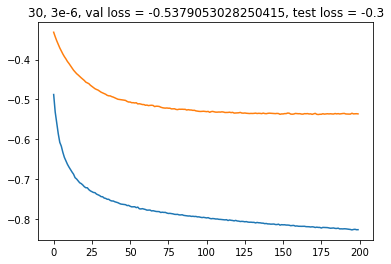

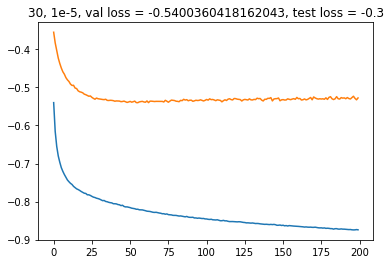

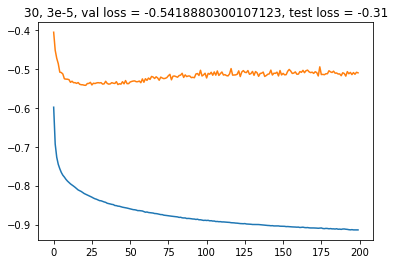

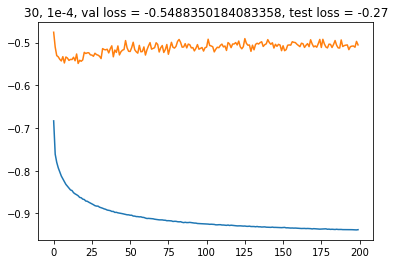

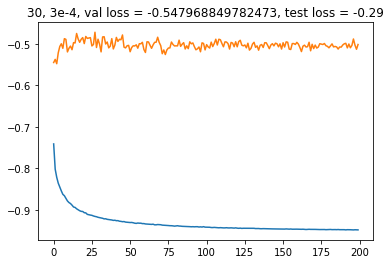

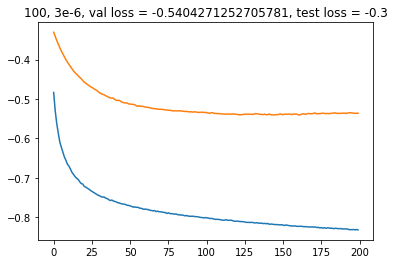

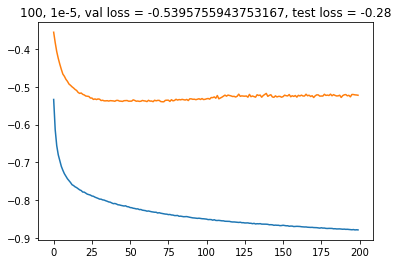

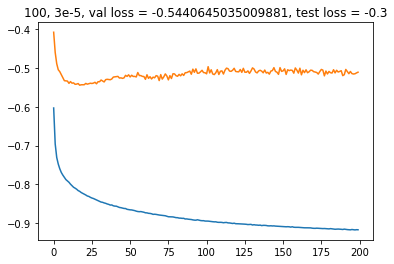

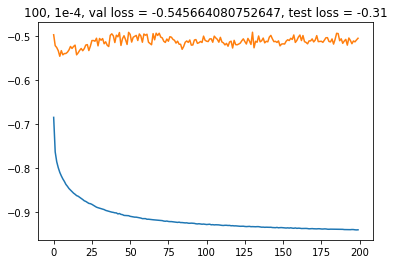

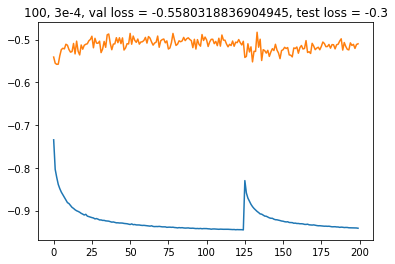

In [41]:
for a in [1, 3, 10, 30, 100]:
    for b in ["3e-6", "1e-5", "3e-5", "1e-4", "3e-4"]:
        f = open(f"../../finetune_results_output/run_noreg/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(200)]

        testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
        valloss = min(vloss)
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
        plt.show()

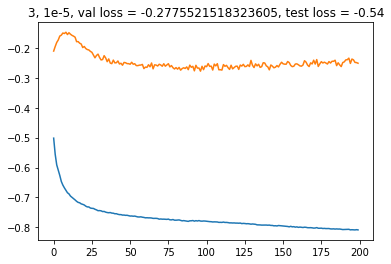

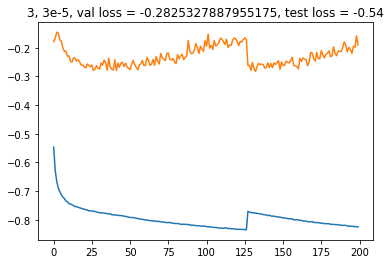

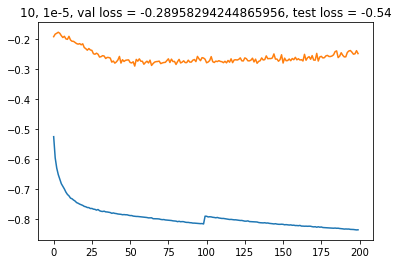

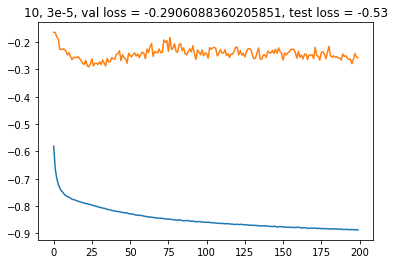

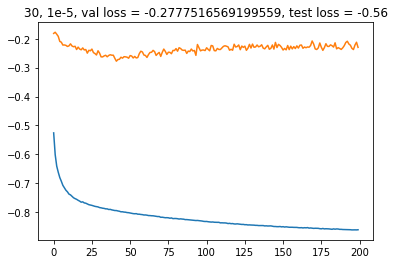

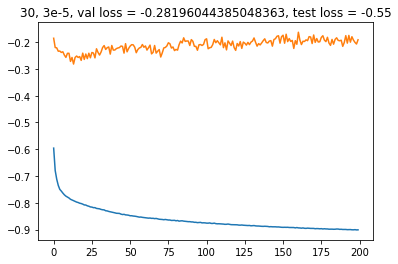

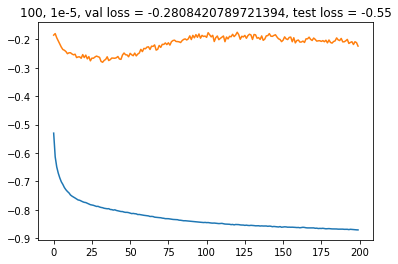

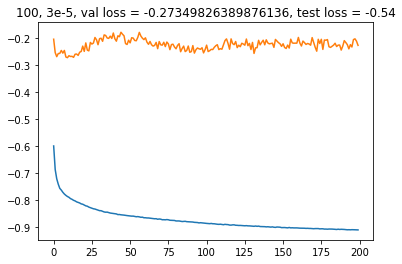

In [39]:
for a in [3, 10, 30, 100]:
    for b in ["1e-5", "3e-5"]:
        f = open(f"../../finetune_results_output/permute1/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(200)]

        testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
        valloss = min(vloss)
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
        plt.show()

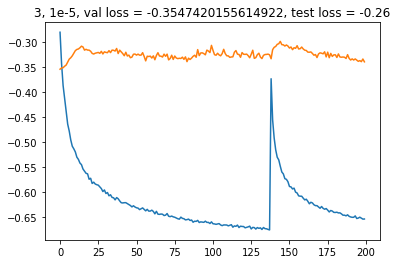

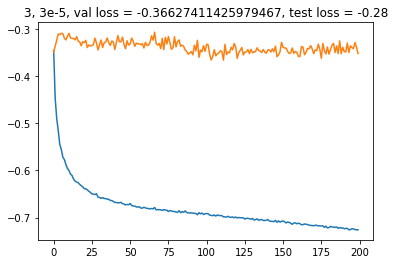

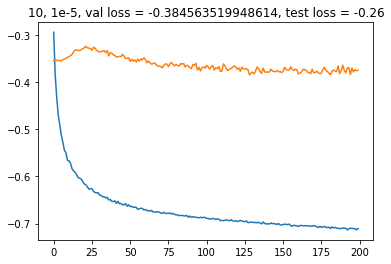

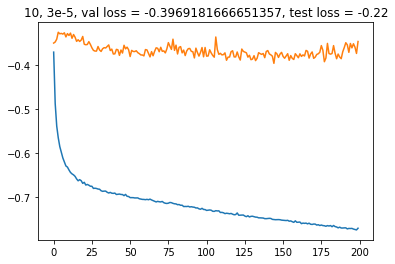

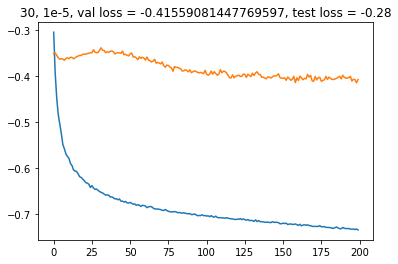

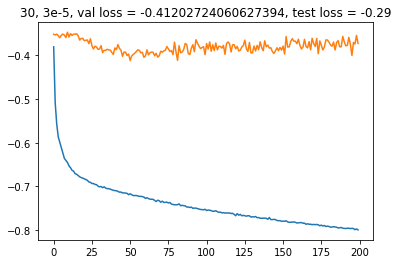

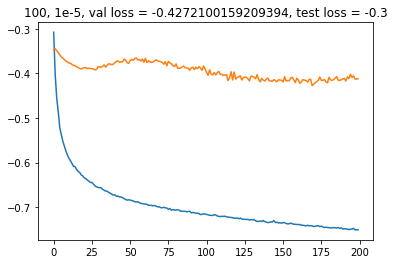

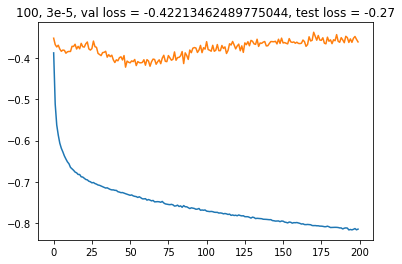

In [38]:
for a in [3, 10, 30, 100]:
    for b in ["1e-5", "3e-5"]:
        f = open(f"../../finetune_results_output/permute2/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(200)]

        testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
        valloss = min(vloss)
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
        plt.show()

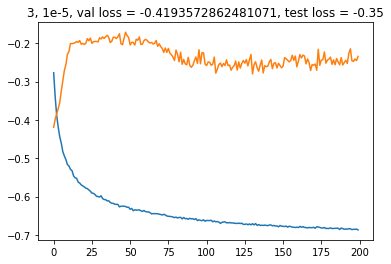

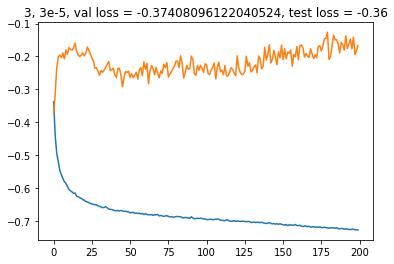

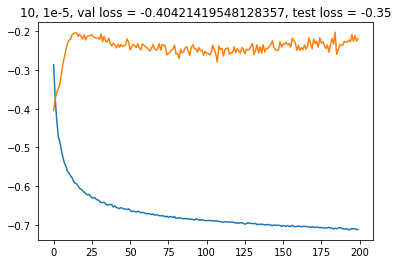

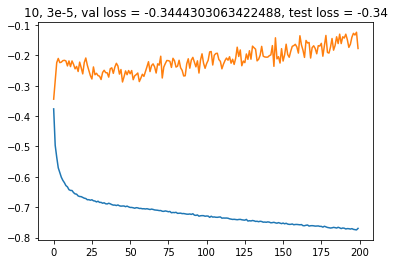

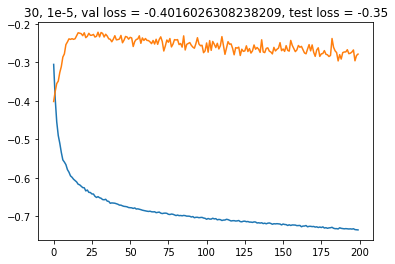

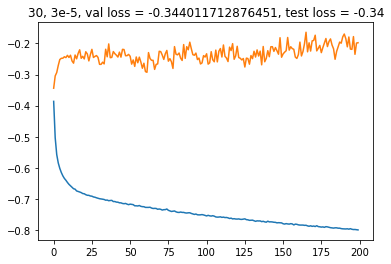

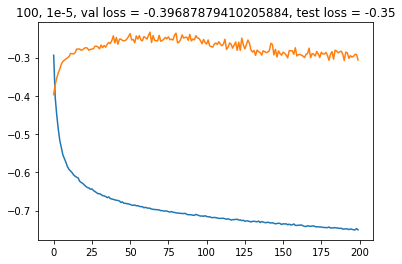

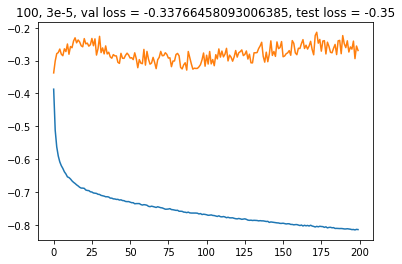

In [14]:
for a in [3, 10, 30, 100]:
    for b in ["1e-5", "3e-5"]:
        f = open(f"../../finetune_results_output/permute3/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(200)]

        testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
        valloss = min(vloss)
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
        plt.show()

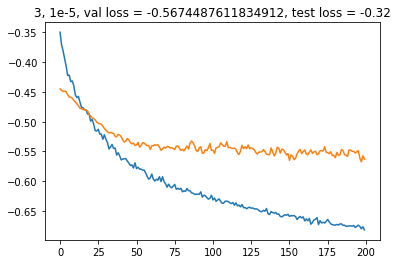

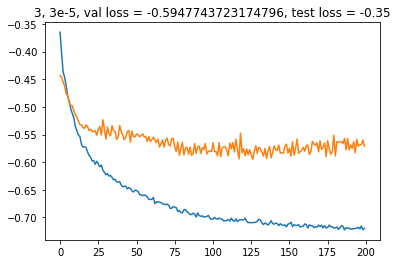

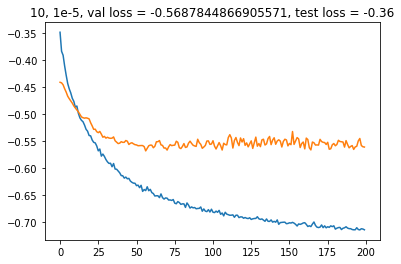

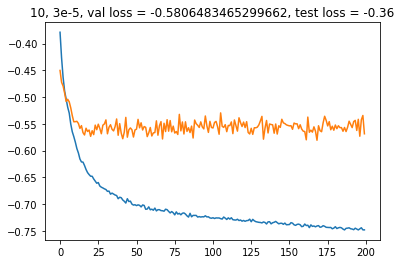

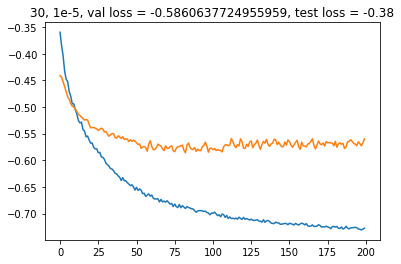

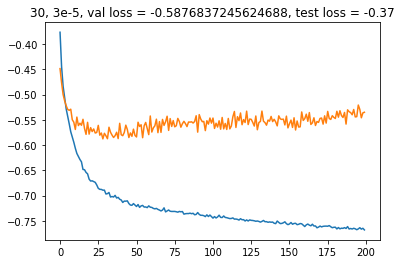

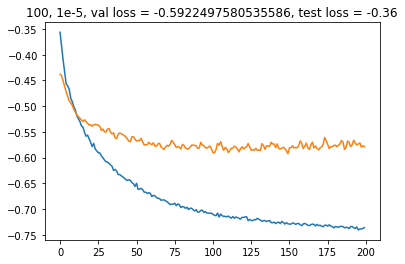

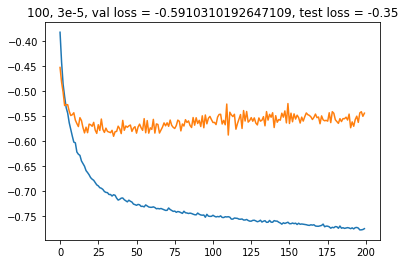

In [15]:
for a in [3, 10, 30, 100]:
    for b in ["1e-5", "3e-5"]:
        f = open(f"../../finetune_results_output/permute4/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(200)]

        testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
        valloss = min(vloss)
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
        plt.show()

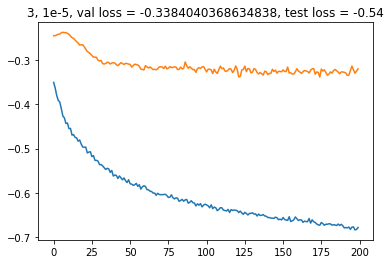

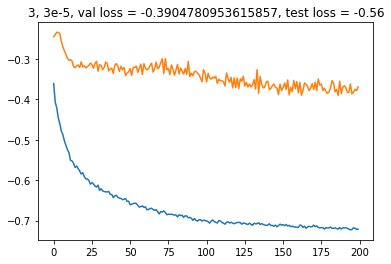

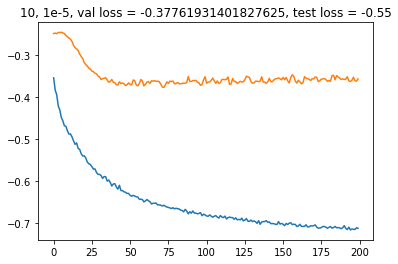

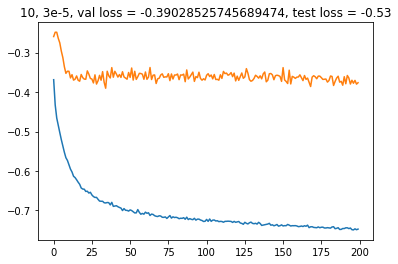

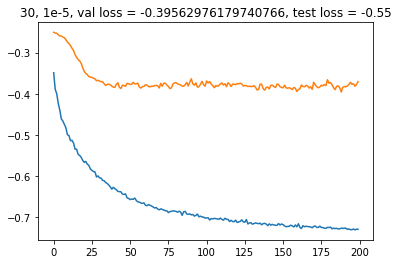

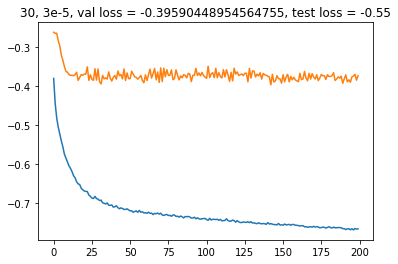

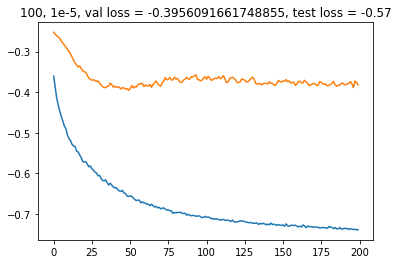

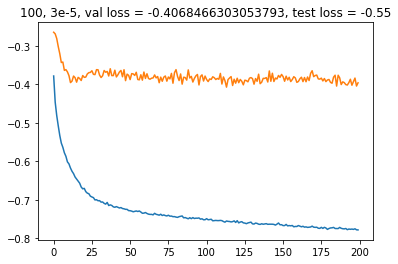

In [16]:
for a in [3, 10, 30, 100]:
    for b in ["1e-5", "3e-5"]:
        f = open(f"../../finetune_results_output/permute5/{a}_{b}.out", "r")
        l = f.readlines()
        d = eval(l[-2])
        tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
        vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
        epochs = [i for i in range(200)]

        testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
        valloss = min(vloss)
        plt.figure()
        plt.plot(epochs, tloss)
        plt.plot(epochs, vloss)
        plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
        plt.show()

In [24]:
overlaps = set()
with open("../../bcl2_blast.txt") as f:
    l = f.readlines()
    for line in l:
        s = line.strip().split("\t")
        if len(s) == 11:
            pident = float(s[-1])
            if pident >= 50:
                print(s[1])
                overlaps.add(s[1].split('|')[1])

pdb|5FMJ|A
pdb|4Z9V|B
pdb|4A1U|A
pdb|4Z9V|A
pdb|5B1Z|B
pdb|5B1Z|A
pdb|4C5D|B
pdb|4C52|B
pdb|2YJ1|A
pdb|6DCO|B
pdb|6DCO|A
pdb|2P1L|A
pdb|5FMK|A
pdb|4A1W|A
pdb|6DCN|B
pdb|6DCN|A
pdb|4A1W|D
pdb|3INQ|B
pdb|2YJ1|C
pdb|4C5D|A
pdb|4C52|A
pdb|2YQ7|A
pdb|2YQ6|A
pdb|3R85|A
pdb|5C3G|A
pdb|3INQ|A
pdb|4BPK|A
pdb|4BPK|B
pdb|3ZK6|A
pdb|3SPF|A
pdb|3SP7|A
pdb|1R2I|A
pdb|3FDL|A
pdb|4EHR|A
pdb|1R2D|A
pdb|1MAZ|A
pdb|4QNQ|A
pdb|2BZW|A
pdb|3ZLN|A
pdb|1R2H|A
pdb|3IHC|A
pdb|6RNU|B
pdb|6RNU|A
pdb|3IO8|A
pdb|1R2E|A
pdb|1PQ0|A
pdb|4QVF|A
pdb|1AF3|A
pdb|1PQ1|A
pdb|3QKD|A
pdb|4YK9|A
pdb|4QVE|A
pdb|3IIG|A
pdb|3WIZ|B
pdb|3WIZ|A
pdb|3IHD|A
pdb|3ILC|A
pdb|4YJ4|A
pdb|2YXJ|A
pdb|3IHF|A
pdb|3ILB|A
pdb|4QVX|B
pdb|4QVX|A
pdb|6QGH|A
pdb|6QGJ|A
pdb|6QG8|A
pdb|6QGG|A
pdb|6QGK|A
pdb|5VAY|A
pdb|5VAU|A
pdb|2W3L|A
pdb|4LVT|A
pdb|5AGX|A
pdb|6GL8|A
pdb|5VAX|A
pdb|6IWB|B
pdb|4IEH|A
pdb|4LXD|A
pdb|5FCG|A
pdb|5JSN|A
pdb|6O0K|A
pdb|4AQ3|A
pdb|6O0M|A
pdb|6O0O|A
pdb|6O0P|A
pdb|6O0L|A
pdb|4MAN|A
pdb|4K5B|D
pdb|2Y6W|B
pdb|2Y6W|A
pdb|4CIM|B

In [25]:
print(overlaps)

{'6RNU', '6DCN', '6QG8', '5VAU', '6B4L', '4G35', '1R2I', '1R2H', '6O0K', '6OQB', '4BD6', '2Y6W', '6UDI', '6U64', '5AJK', '4BD8', '4ZIH', '6DCO', '4MAN', '6QFM', '4A1U', '2JBY', '6GL8', '6OQD', '4ZEQ', '3IHF', '2P1L', '4YJ4', '5C3F', '4BPJ', '6VO4', '3R85', '4Z9V', '5UA5', '4ZBI', '5UUL', '6MBC', '5VWX', '6U65', '6B4U', '3IIG', '4A1W', '1PQ0', '5VWY', '4EHR', '3ZLN', '3PK1', '4BPK', '1PQ1', '5B1Z', '5VWV', '6EB6', '6O6F', '3MQP', '2YQ7', '4CIM', '5AGX', '4C52', '5FC4', '3QKD', '6UDX', '3ZK6', '3INQ', '4QVX', '6QGK', '3WIY', '6QZ5', '2VOG', '4BD2', '6QZB', '5VAY', '6QYP', '6UDT', '6UDV', '6QGH', '3KJ1', '5FCG', '2VOH', '5WHH', '6MBB', '4ZIF', '5FMJ', '5JSN', '5WOS', '3MK8', '5AJJ', '6FS2', '4S0O', '2IMT', '3ILB', '4QNQ', '2PQK', '6UD2', '6NE5', '3KJ2', '5WHI', '4LXD', '6IWB', '3IO8', '4AQ3', '3WIZ', '6FS1', '5KU9', '4QVE', '3IHC', '3WIX', '3ILC', '6MBE', '4B4S', '5UUP', '5W60', '4ZII', '6UDY', '4ZIE', '2YJ1', '4LVT', '4UF1', '5IF4', '1R2D', '2JCN', '4BPI', '2XPX', '6P3P', '6RJP', '5VAX',

In [26]:
reverse_overlaps = {'6O4U_A', '5JSN_A', '5VAY_A', '6DCN_A', '6NE5_A', '6MBD_A', '6E3J_A', '6MBE_A', '3IO9_A', '3INQ_B', '5VAU_E', '3INQ_A', '4ZIF_B', '4AQ3_A', '4BPI_A', '3ILB_A', '4QVX_A', '6B4U_A', '2YQ6_A', '3I1H_B', '6DCN_D', '6DCO_D', '6QZ8_A', '4ZIG_B', '5UUK_B', '3SPF_A', '3MK8_A', '3KJ0_A', '4OQ6_A', '6IWB_B', '2Y6W_A', '5UUP_A', '6QG8_A', '6UDU_A', '5VWY_B', '1PQ0_A', '3FDL_B', '5VWV_B', '2NL9_B', '2P1L_B', '3KJ2_A', '5B1Z_B', '4BD2_C', '6RJP_A', '6QGJ_A', '4BPK_A', '6DCO_A', '2VM6_A', '4C5D_A', '3IHD_A', '3KJ1_A', '4ZIH_B', '5FMK_A', '2XPX_B', '2VOI_B', '5KU9_A', '1MAZ_A', '2PQK_B', '6MBC_A', '3WIY_A', '6OQC_A', '2YJ1_A', '5AJJ_B', '2JBY_B', '6O0L_A', '4CIM_B', '6QGG_A', '6QGK_A', '5FC4_A', '5UUP_B', '2YQ7_B', '5UUM_C', '4UF1_B', '4QNQ_A', '3MQP_B', '1R2I_A', '2VOI_A', '2WH6_B', '3DVU_C', '6UDT_A', '3I1H_A', '4ZBI_A', '4ZII_C', '6O0O_A', '5VMO_B', '5AJK_D', '4EHR_A', '4ZIE_C', '5VAX_A', '5B1Z_A', '6QFM_A', '6VO4_A', '3MQP_A', '4IEH_A', '6DCO_C', '6E3I_A', '6FS2_A', '6QFM_B', '3D7V_A', '4HW4_C', '5C3G_A', '2PQK_A', '6DCO_B', '4A1W_A', '6UDX_A', '4QVF_B', '5UUL_B', '2YQ7_A', '3IO8_A', '5C3F_A', '3KZ0_C', '5FMJ_B', '2VM6_B', '5UUL_A', '3FDL_A', '5WHH_A', '6QZB_A', '6O6G_A', '1R2D_A', '2W3L_A', '2VOH_B', '3R85_A', '5UUM_A', '6O0K_A', '6U64_A', '2P1L_A', '3PK1_A', '5UA5_B', '6OQN_A', '4QVE_B', '4K5B_D', '6U67_A', '6O0M_A', '4C52_A', '6QFI_A', '6RNU_A', '2BZW_B', '2VOG_A', '6GL8_A', '6OQB_A', '6O6F_A', '6UD2_A', '4G35_A', '4YK9_B', '3IO9_B', '4D2M_D', '4Z9V_B', '5W89_A', '1AF3_A', '5WOS_B', '3KJ1_B', '6UDV_A', '4MI8_C', '4ZBF_A', '4B4S_B', '5VAU_A', '4D2M_B', '6QGH_A', '5FMK_B', '3WIZ_A', '5VAX_E', '6UDI_A', '3SP7_A', '4BD6_C', '6OQD_A', '5W8F_A', '6U65_A', '6FBX_B', '5FMJ_A', '3BL2_C', '4QVF_A', '4A1W_D', '1PQ1_B', '4QVE_A', '6QYP_A', '3ZLN_A', '3WIX_A', '3IHC_A', '6QFQ_A', '1PQ1_A', '6B4L_A', '6QZ5_A', '3IIG_A', '5IF4_A', '6DCN_B', '4MAN_A', '5AJK_B', '1R2H_A', '4YJ4_A', '4WMR_A', '5VKC_A', '3D7V_B', '6P3P_A', '4ZEQ_A', '4ZEQ_B', '4A1U_A', '3KJ0_B', '6QZ6_A', '5IEZ_A', '5FDR_A', '6QG8_B', '4QVX_B', '5FCG_A', '4C52_B', '3WIZ_B', '6QFI_B', '2Y6W_B', '2BZW_A', '2VOH_A', '5VKC_B', '6TRR_B', '4LVT_A', '5AGX_A', '3QKD_A', '6O0P_A', '6TQP_B', '3ZK6_A', '3KJ2_B', '6FS1_A', '3IHF_A', '6DCN_C', '2YXJ_A', '1R2E_A', '3PK1_B', '5UUK_A', '6MBB_A', '4C5D_B', '2YJ1_C', '3KZ0_A', '5WHI_A', '4HW4_A', '4LXD_A', '4YK9_A', '6UDY_A', '3IO8_B', '4BPJ_A', '4BPK_B', '5VAY_E', '4Z9V_A', '6RNU_B', '2NL9_A', '3ILC_A', '4YJ4_B', '4HW3_A'}


In [28]:
r_overlaps = {i[:-2] for i in reverse_overlaps}
print(r_overlaps - overlaps)
print(overlaps - r_overlaps)

{'4MI8', '5VMO', '6FBX'}
{'5FMI', '2YV6', '4BD8', '5W60', '5W62', '5VWX', '4S0O', '2IMT', '6EB6', '5W61', '2IMS', '2JCN'}


In [35]:
count = 0
with open("nooverlap_train.in", "a") as g:
    with open("../../multichain_train.in") as f:
        line = f.readline()
        while line:
            if line.strip() in r_overlaps:
                count += 1
            else:
                g.write(line)
            line = f.readline()
print(count)

47


In [32]:
print(len(r_overlaps))

185


In [36]:
count = 0
with open("nooverlap_validation.in", "a") as g:
    with open("../../multichain_validation.in") as f:
        line = f.readline()
        while line:
            if line.strip() in r_overlaps:
                count += 1
            else:
                g.write(line)
            line = f.readline()
print(count)

5


In [37]:
count = 0
with open("nooverlap_test.in", "a") as g:
    with open("../../multichain_test.in") as f:
        line = f.readline()
        while line:
            if line.strip() in r_overlaps:
                count += 1
            else:
                g.write(line)
            line = f.readline()
print(count)

0


In [ ]:
# with open('bcl2.fasta', 'a') as fasta:
#     for f in tqdm(files):
#         features = pd.read_pickle(f)
#         lens = features['chain_lens']
#         for i in range(len(lens)-1):
#             lens[i+1] += lens[i]
#         lens = [0] + lens
#         seq = ''.join(ints_to_seq(features['sequence']))
#         chains = [seq[lens[i]:lens[i+1]] for i in range(len(lens)-1)]
        
#         name = f.split("/")[0]
#         _ = fasta.write(">{}_A\n{}\n".format(name, chains[0]))
#         _ = fasta.write(">{}_B\n{}\n".format(name, chains[1]))

run_noreg
-0.4954590498595165 -0.29 3 1e-5


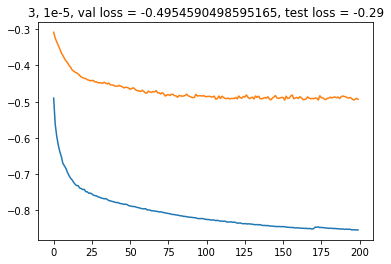

-0.5265522150167863 -0.34 3 3e-5


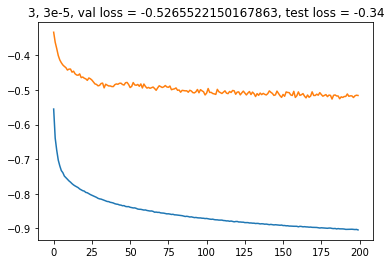

-0.5176676310924976 -0.32 10 1e-5


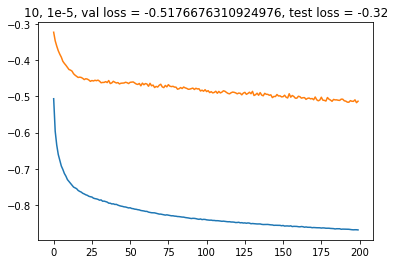

-0.5435956697706177 -0.32 10 3e-5


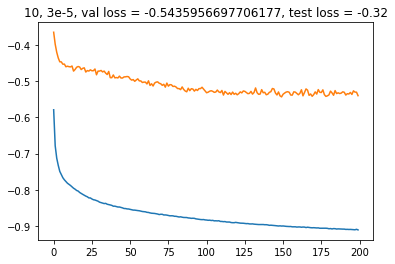

-0.5306966579262522 -0.32 30 1e-5


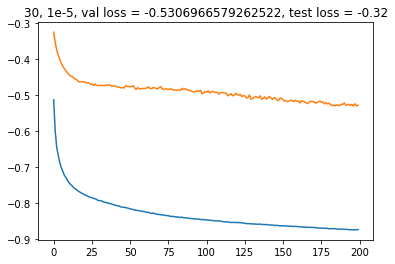

-0.5457962790736348 -0.32 30 3e-5


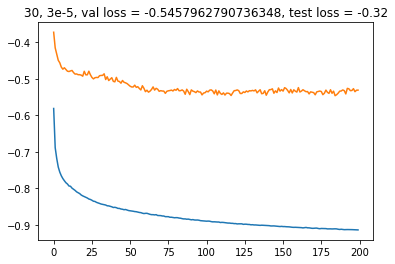

-0.5424070197013021 -0.33 100 1e-5


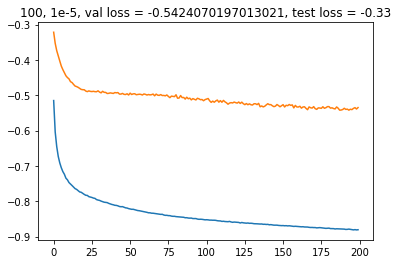

-0.5502491558921703 -0.32 100 3e-5


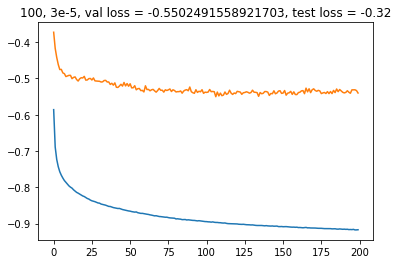

run_noreg_p1
-0.2973400092663654 -0.49 3 1e-5


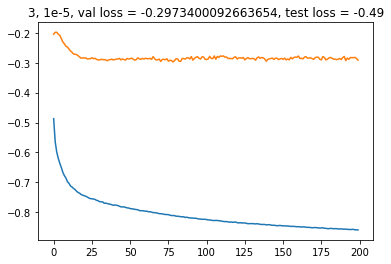

-0.3307530179562921 -0.53 3 3e-5


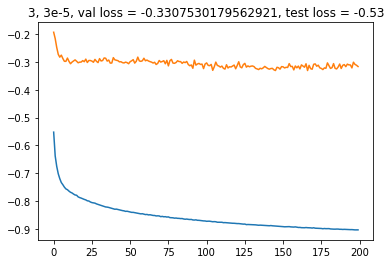

-0.3271194192194305 -0.45 10 1e-5


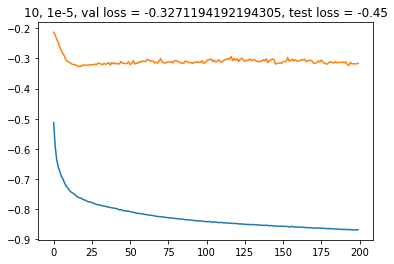

-0.33306292243408486 -0.47 10 3e-5


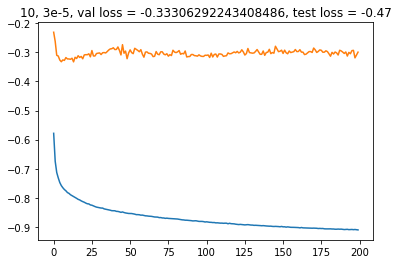

-0.35275395407193927 -0.47 30 1e-5


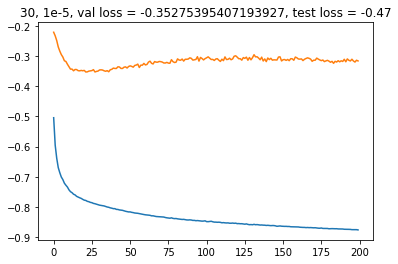

-0.3567304041975944 -0.46 30 3e-5


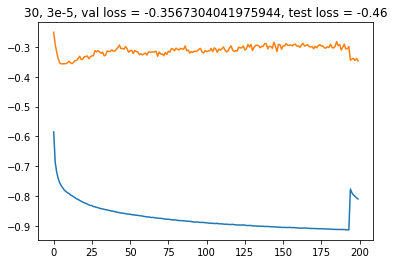

-0.3789938903334095 -0.48 100 1e-5


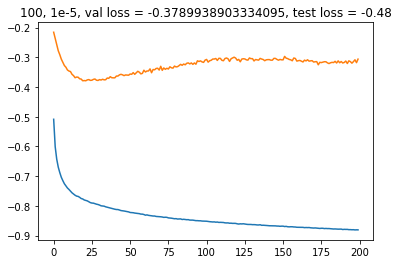

-0.37580153604435124 -0.49 100 3e-5


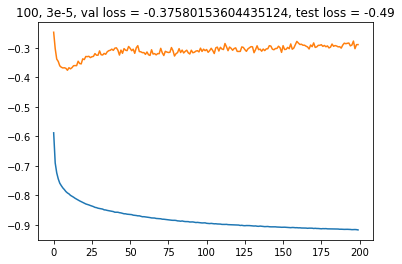

run_noreg_p4
-0.6016303247566808 -0.37 3 1e-5


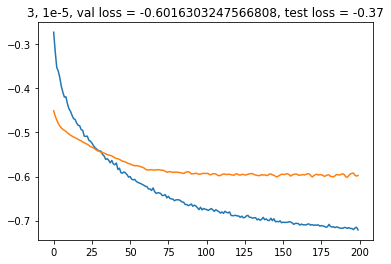

-0.6184015904883389 -0.38 3 3e-5


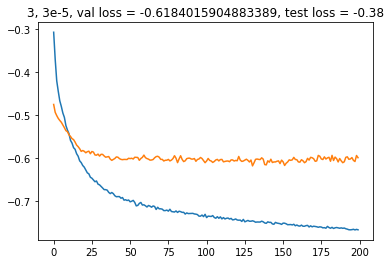

-0.6132303197604418 -0.36 10 1e-5


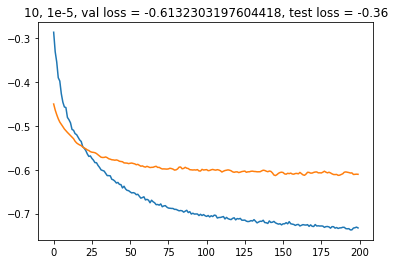

-0.6147448318838593 -0.37 10 3e-5


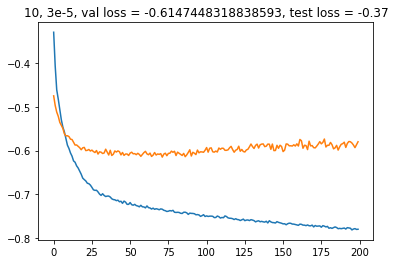

-0.604584359516593 -0.37 30 1e-5


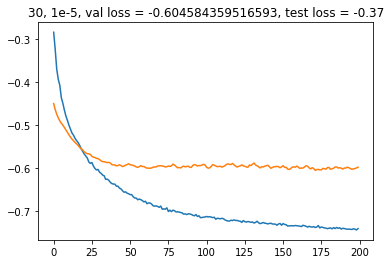

-0.5988889749371846 -0.37 30 3e-5


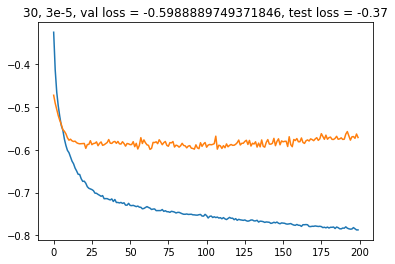

-0.5975735032546668 -0.38 100 1e-5


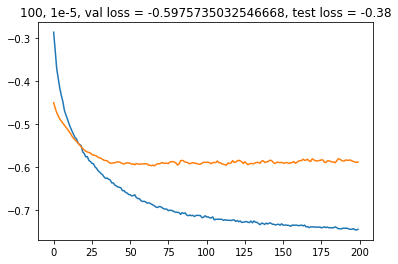

-0.6084666876675595 -0.36 100 3e-5


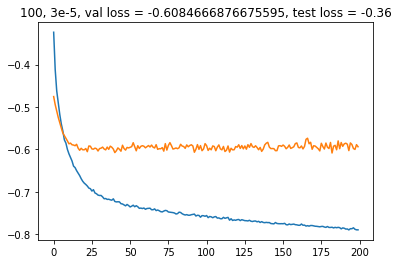

run_noreg_p5
-0.37969045830802706 -0.59 3 1e-5


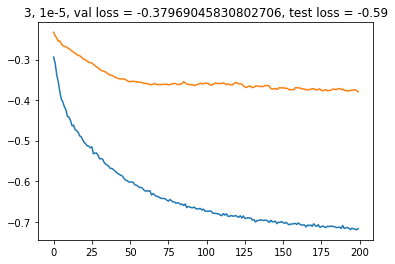

-0.40752991342257294 -0.59 3 3e-5


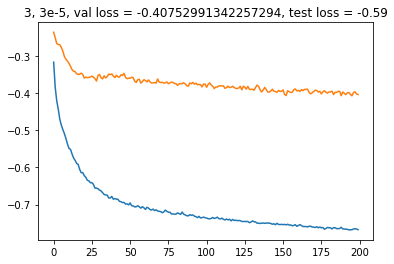

-0.38029201049172906 -0.6 10 1e-5


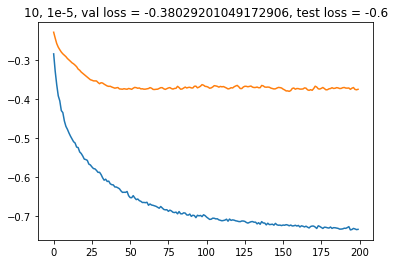

-0.4020634137677373 -0.58 10 3e-5


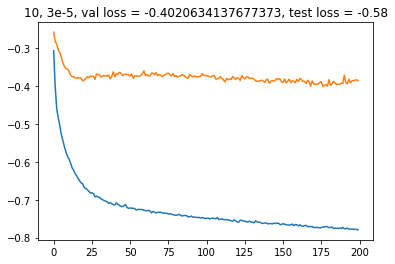

-0.39045033293208975 -0.59 30 1e-5


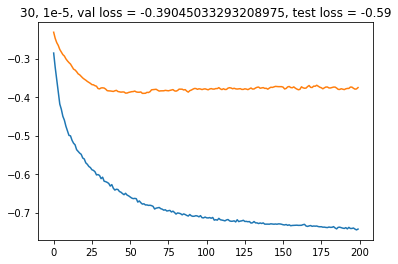

-0.39734960919414936 -0.6 30 3e-5


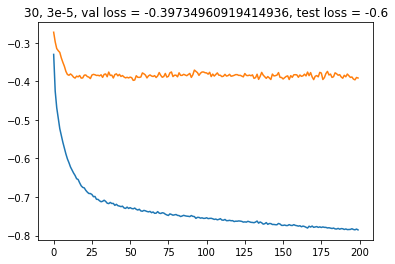

-0.38955895246678157 -0.59 100 1e-5


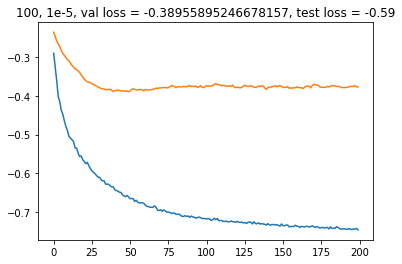

-0.39538766653147644 -0.59 100 3e-5


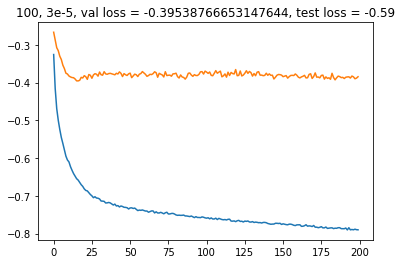

In [54]:
# for c in ['run_noreg', 'run_noreg_p1', 'run_noreg_p2', 'run_noreg_p3', 'run_noreg_p4', 'run_noreg_p5', 'run_original', 'run_permute1', 'run_permute2', 'run_permute3', 'run_permute4', 'run_permute5']:
for c in ['run_noreg', 'run_noreg_p1', 'run_noreg_p4', 'run_noreg_p5']:
    print(c)
    best = float("inf")
    for a in [3, 10, 30, 100]:
        for b in ["1e-5", "3e-5"]:
            f = open(f"../../finetune_results_output/nooverlaps/{c}/{a}_{b}.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            epochs = [i for i in range(200)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            plt.figure()
            plt.plot(epochs, tloss)
            plt.plot(epochs, vloss)
            plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            plt.show()
    # plt.figure()
    # plt.plot(epochs, plottloss)
    # plt.plot(epochs, plotvloss)
    # plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    # plt.show()

run_noreg
-0.4954590498595165 -0.29 3 1e-5


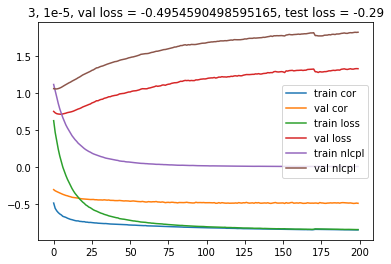

-0.5265522150167863 -0.34 3 3e-5


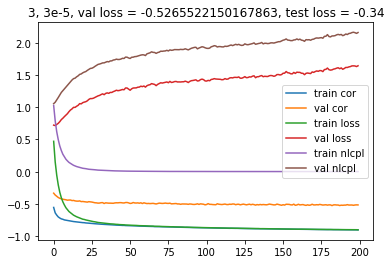

-0.5176676310924976 -0.32 10 1e-5


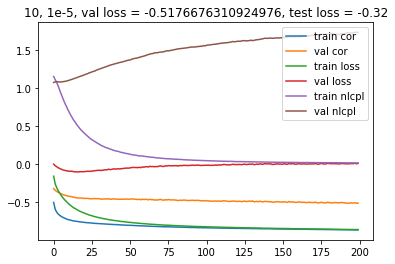

-0.5435956697706177 -0.32 10 3e-5


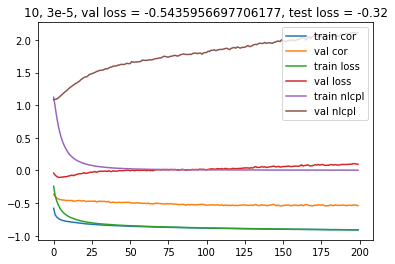

-0.5306966579262522 -0.32 30 1e-5


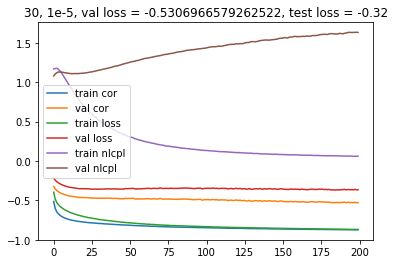

-0.5457962790736348 -0.32 30 3e-5


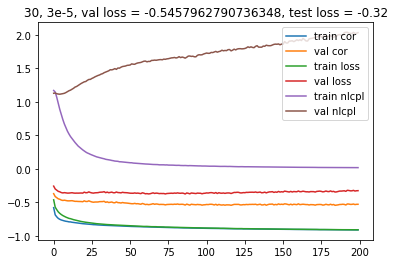

-0.5424070197013021 -0.33 100 1e-5


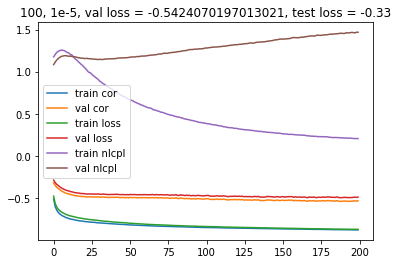

-0.5502491558921703 -0.32 100 3e-5


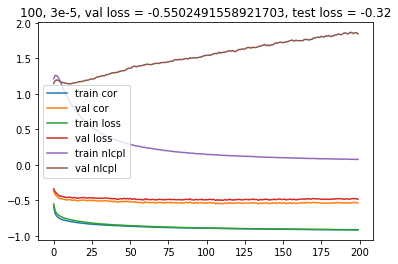

run_noreg_p1
-0.2973400092663654 -0.49 3 1e-5


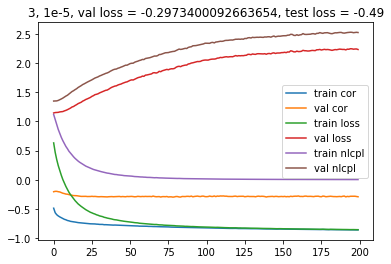

-0.3307530179562921 -0.53 3 3e-5


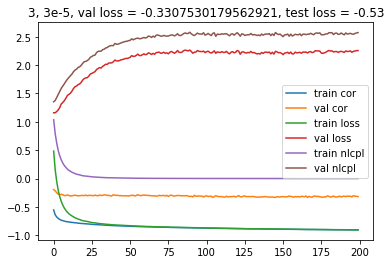

-0.3271194192194305 -0.45 10 1e-5


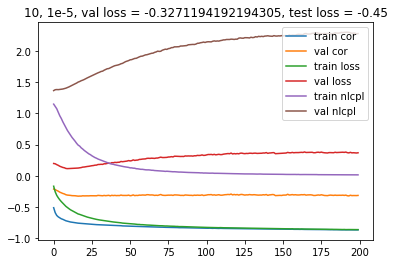

-0.33306292243408486 -0.47 10 3e-5


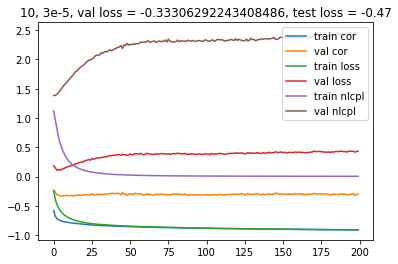

-0.35275395407193927 -0.47 30 1e-5


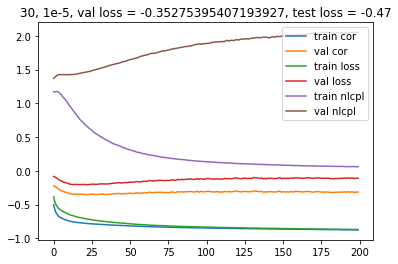

-0.3567304041975944 -0.46 30 3e-5


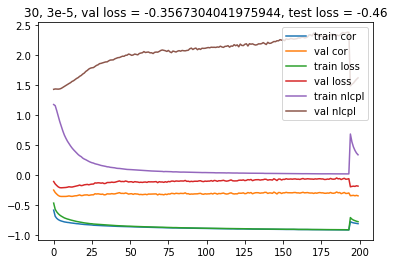

-0.3789938903334095 -0.48 100 1e-5


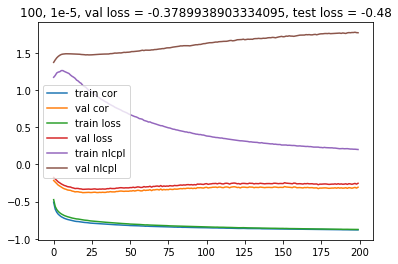

-0.37580153604435124 -0.49 100 3e-5


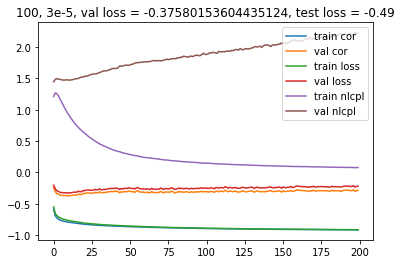

run_original
-0.4841643052271662 -0.28 3 1e-5


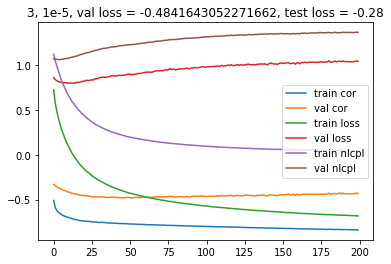

-0.4853376101358725 -0.28 3 3e-5


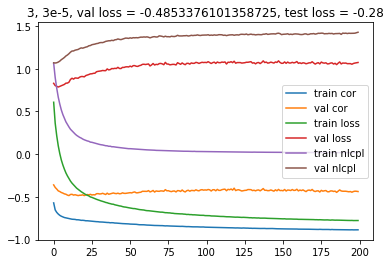

-0.4992528786920446 -0.31 10 1e-5


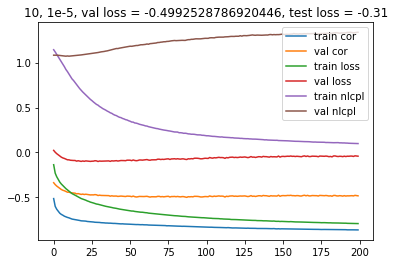

-0.5045987735613774 -0.3 10 3e-5


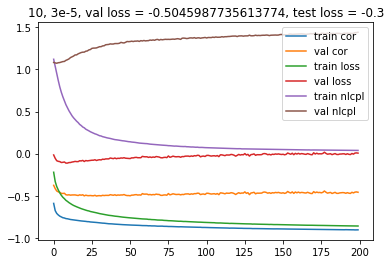

-0.5120716070582235 -0.24 30 1e-5


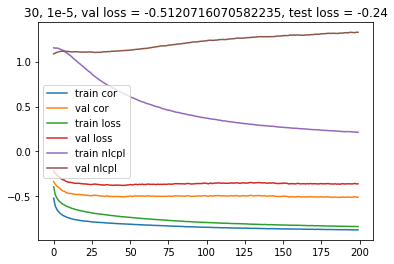

-0.5202178594295601 -0.27 30 3e-5


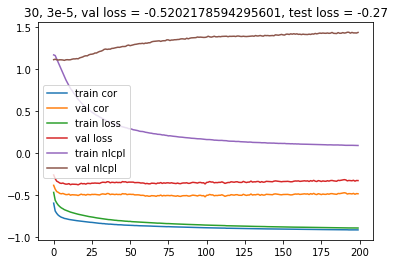

-0.5410758855481698 -0.24 100 1e-5


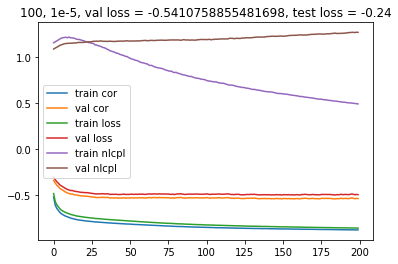

-0.5446832615837782 -0.26 100 3e-5


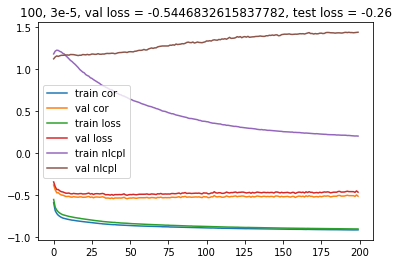

run_permute1
-0.28804667714754123 -0.46 3 1e-5


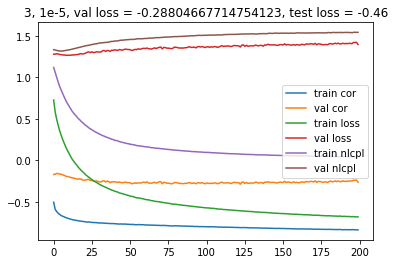

-0.2983455102088189 -0.46 3 3e-5


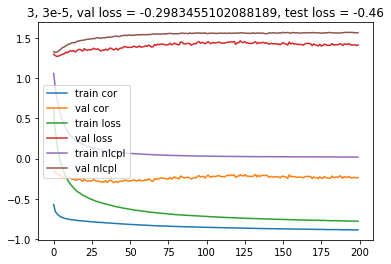

-0.3130204059103407 -0.48 10 1e-5


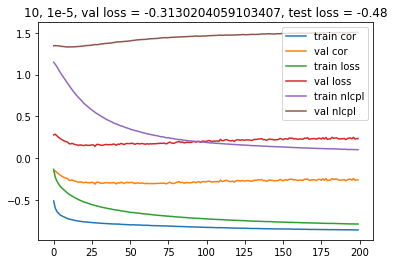

-0.30897112715292024 -0.49 10 3e-5


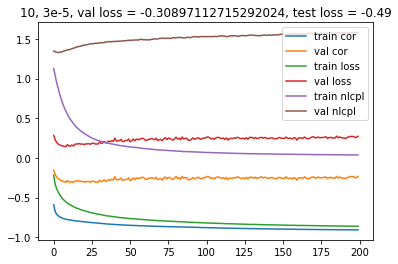

-0.33619777353252844 -0.5 30 1e-5


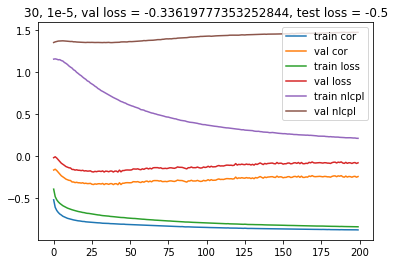

-0.34822019196308496 -0.5 30 3e-5


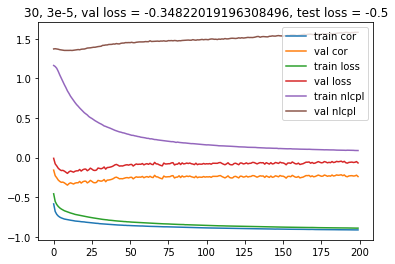

-0.35789902658679795 -0.52 100 1e-5


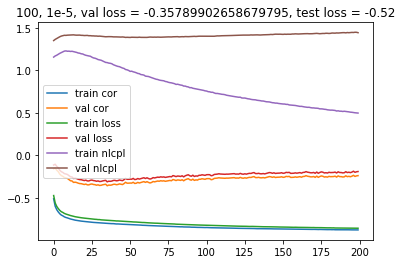

-0.3627796694671729 -0.52 100 3e-5


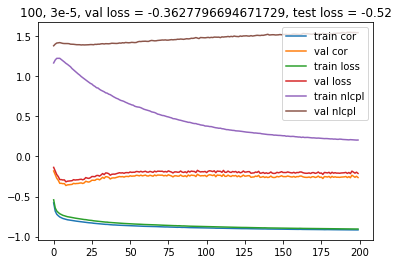

In [62]:
# for c in ['run_noreg', 'run_noreg_p1', 'run_noreg_p2', 'run_noreg_p3', 'run_noreg_p4', 'run_noreg_p5', 'run_original', 'run_permute1', 'run_permute2', 'run_permute3', 'run_permute4', 'run_permute5']:
for c in ['run_noreg', 'run_noreg_p1', 'run_original', 'run_permute1']:
    print(c)
    best = float("inf")
    for a in [3, 10, 30, 100]:
        for b in ["1e-5", "3e-5"]:
            f = open(f"../../finetune_results_output/nooverlaps/{c}/{a}_{b}.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            fulltloss = [x[0]/a for x in d['train_loss']]
            fullvloss = [x[0]/a for x in d['val_loss']]
            tnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['train_loss']]
            vnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['val_loss']]
            epochs = [i for i in range(200)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            plt.figure()
            plt.plot(epochs, tloss)
            plt.plot(epochs, vloss)
            plt.plot(epochs, fulltloss)
            plt.plot(epochs, fullvloss)
            plt.plot(epochs, tnlcpl)
            plt.plot(epochs, vnlcpl)
            plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            plt.legend(["train cor", "val cor", "train loss", "val loss", "train nlcpl", "val nlcpl"])
            plt.show()
    # plt.figure()
    # plt.plot(epochs, plottloss)
    # plt.plot(epochs, plotvloss)
    # plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    # plt.show()

multi_noreg_p0
-0.4858014459313812 -0.35 30 3e-6
-0.5151922111198222 -0.34 30 1e-5
-0.49228061309923926 -0.38 100 3e-6
-0.5222928954707268 -0.34 100 1e-5
-0.49767877141577477 -0.38 300 3e-6
-0.5276846876155579 -0.34 300 1e-5
-0.5007213344087093 -0.38 1000 3e-6
-0.5361904498526181 -0.35 1000 1e-5


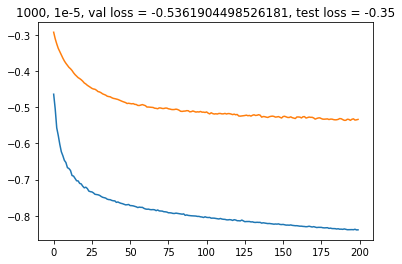

multi_noreg_p1
-0.35687073099031397 -0.48 30 3e-6
-0.36358576787866387 -0.49 30 1e-5
-0.37908257166842174 -0.49 100 3e-6
-0.381490047737763 -0.5 100 1e-5
-0.382578404421353 -0.5 300 3e-6
-0.3870733269229728 -0.51 300 1e-5
-0.3862886313979319 -0.5 1000 3e-6
-0.391325971904914 -0.52 1000 1e-5


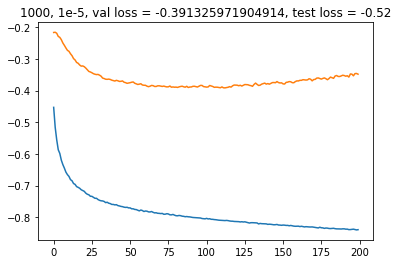

multi_reg_p0
-0.49031661583467306 -0.32 30 3e-6
-0.49973516913537613 -0.32 30 1e-5
-0.512247637212422 -0.34 100 3e-6
-0.5344322984597579 -0.33 100 1e-5
-0.5221896847132368 -0.34 300 3e-6
-0.5549748964548387 -0.31 300 1e-5
-0.5265135197055095 -0.35 1000 3e-6
-0.5605407633924824 -0.32 1000 1e-5


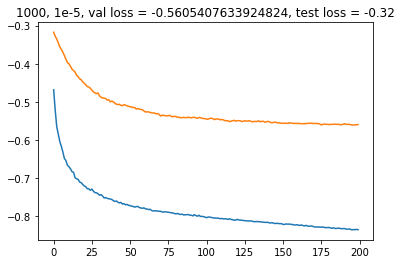

multi_reg_p1
-0.32979623780039335 -0.49 30 3e-6
-0.33887320340409877 -0.5 30 1e-5
-0.3450837206553617 -0.51 100 3e-6
-0.35390016739101277 -0.52 100 1e-5
-0.342666224645714 -0.52 300 3e-6
-0.361425795738857 -0.53 300 1e-5
-0.34884865901224715 -0.53 1000 3e-6
-0.35433743764313025 -0.54 1000 1e-5


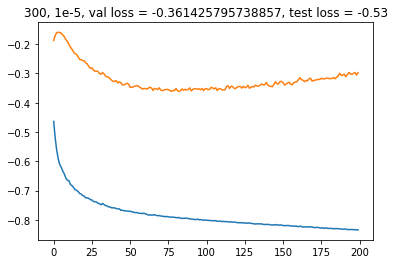

single_noreg_p0
-0.4896112612874857 -0.29 30 3e-6
-0.53576758479212 -0.22 30 1e-5
-0.5099912178321218 -0.33 100 3e-6
-0.552678276034498 -0.28 100 1e-5
-0.5215615075421899 -0.36 300 3e-6
-0.562259760786655 -0.31 300 1e-5
-0.5253769384479364 -0.36 1000 3e-6
-0.5676695907756077 -0.34 1000 1e-5


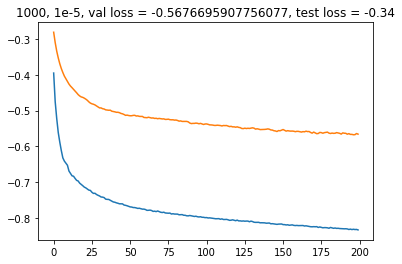

single_noreg_p1
-0.2915929293901236 -0.49 30 3e-6
-0.2917943038897415 -0.49 30 1e-5
-0.3388971633182701 -0.51 100 3e-6
-0.3390988629046749 -0.51 100 1e-5
-0.35630205230769185 -0.52 300 3e-6
-0.36222880277452135 -0.54 300 1e-5
-0.3574847125182324 -0.52 1000 3e-6
-0.3788485021180878 -0.56 1000 1e-5


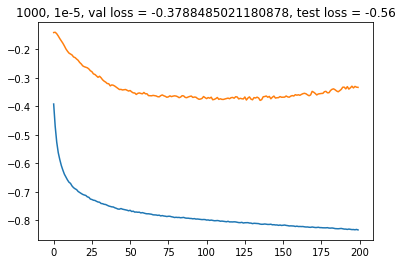

In [2]:
for c in ['multi_noreg_p0', 'multi_noreg_p1', 'multi_reg_p0', 'multi_reg_p1', 'single_noreg_p0', 'single_noreg_p1']:
    print(c)
    best = float("inf")
    for a in [30, 100, 300, 1000]:
        for b in ["3e-6", "1e-5"]:
            f = open(f"../../finetune_results_output/round2/{c}/{a}_{b}.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            epochs = [i for i in range(200)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            # plt.figure()
            # plt.plot(epochs, tloss)
            # plt.plot(epochs, vloss)
            # plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            # plt.show()
    plt.figure()
    plt.plot(epochs, plottloss)
    plt.plot(epochs, plotvloss)
    plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    plt.show()

multi_reg_p0
-0.49031661583467306 -0.32 30 3e-6


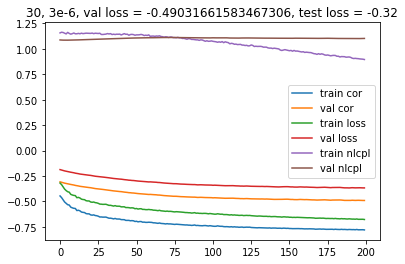

-0.49973516913537613 -0.32 30 1e-5


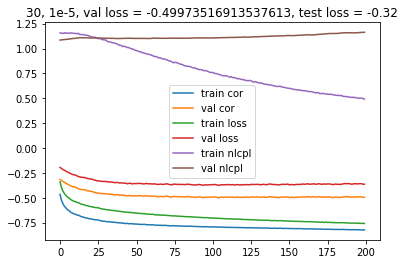

-0.512247637212422 -0.34 100 3e-6


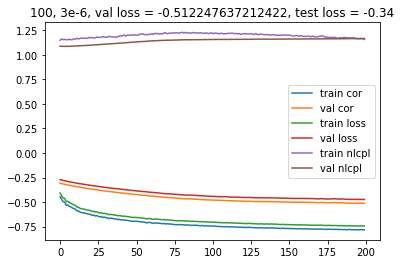

-0.5344322984597579 -0.33 100 1e-5


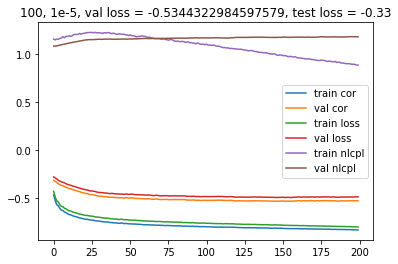

-0.5221896847132368 -0.34 300 3e-6


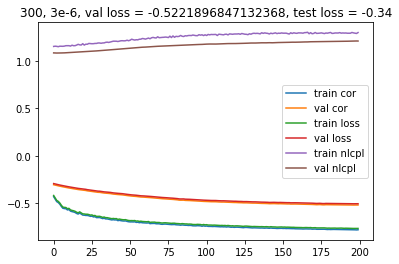

-0.5549748964548387 -0.31 300 1e-5


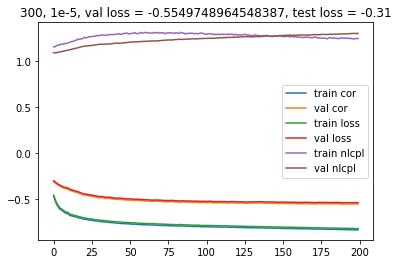

-0.5265135197055095 -0.35 1000 3e-6


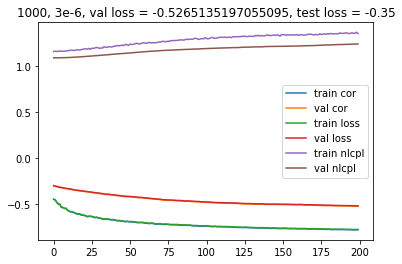

-0.5605407633924824 -0.32 1000 1e-5


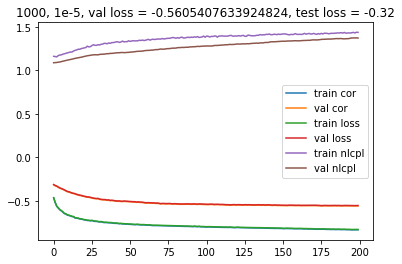

multi_reg_p1
-0.32979623780039335 -0.49 30 3e-6


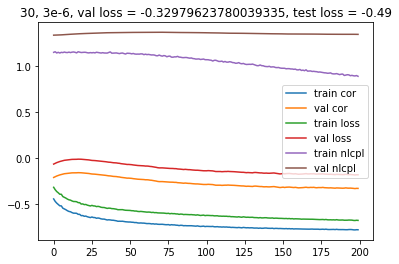

-0.33887320340409877 -0.5 30 1e-5


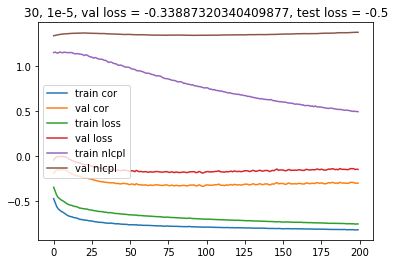

-0.3450837206553617 -0.51 100 3e-6


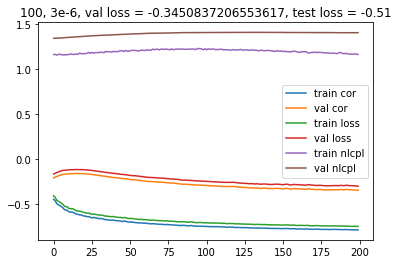

-0.35390016739101277 -0.52 100 1e-5


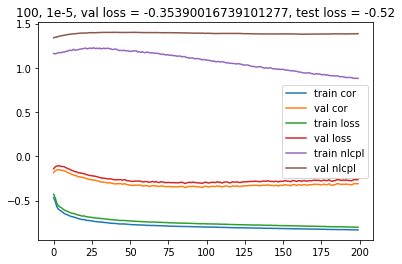

-0.342666224645714 -0.52 300 3e-6


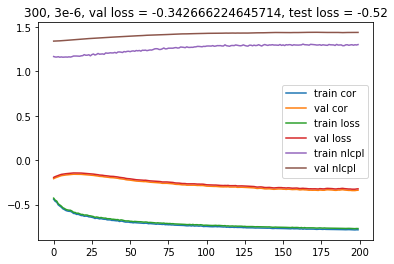

-0.361425795738857 -0.53 300 1e-5


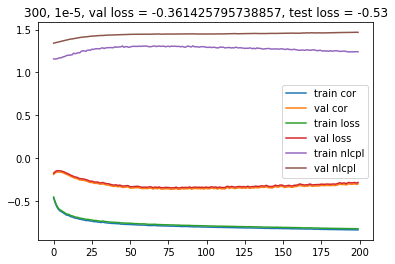

-0.34884865901224715 -0.53 1000 3e-6


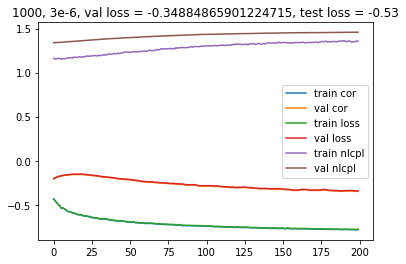

-0.35433743764313025 -0.54 1000 1e-5


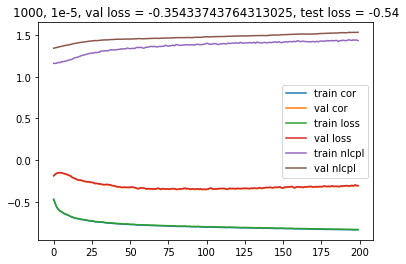

In [4]:
for c in ['multi_reg_p0', 'multi_reg_p1']:
    print(c)
    best = float("inf")
    for a in [30, 100, 300, 1000]:
        for b in ["3e-6", "1e-5"]:
            f = open(f"../../finetune_results_output/round2/{c}/{a}_{b}.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            fulltloss = [x[0]/a for x in d['train_loss']]
            fullvloss = [x[0]/a for x in d['val_loss']]
            tnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['train_loss']]
            vnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['val_loss']]
            epochs = [i for i in range(200)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            plt.figure()
            plt.plot(epochs, tloss)
            plt.plot(epochs, vloss)
            plt.plot(epochs, fulltloss)
            plt.plot(epochs, fullvloss)
            plt.plot(epochs, tnlcpl)
            plt.plot(epochs, vnlcpl)
            plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            plt.legend(["train cor", "val cor", "train loss", "val loss", "train nlcpl", "val nlcpl"])
            plt.show()
    # plt.figure()
    # plt.plot(epochs, plottloss)
    # plt.plot(epochs, plotvloss)
    # plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    # plt.show()

multi_noreg_p0
-0.5363056663237019 -0.36 0 1e-5
-0.5429221649055598 -0.35 1 1e-5
-0.5410491125232983 -0.35 2 1e-5
-0.5625633837607571 -0.32 0 3e-5
-0.5652260315070212 -0.32 1 3e-5
-0.563919402612272 -0.33 2 3e-5


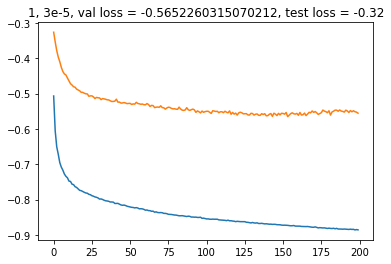

multi_noreg_p1
-0.3941038866320157 -0.5 0 1e-5
-0.39742176069663976 -0.52 1 1e-5
-0.3873468903815592 -0.52 2 1e-5
-0.3927024330130392 -0.52 0 3e-5
-0.39643662889550546 -0.52 1 3e-5
-0.3903158199185299 -0.52 2 3e-5


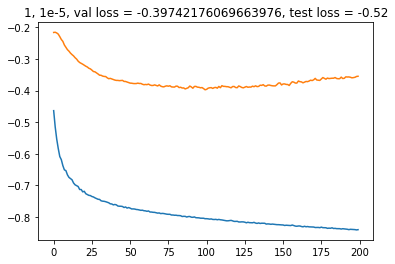

multi_reg_p0
-0.5644654119370184 -0.33 0 1e-5
-0.5654849469376385 -0.32 1 1e-5
-0.5660174741824253 -0.32 2 1e-5
-0.5765641823166342 -0.28 0 3e-5
-0.5763637073620331 -0.26 1 3e-5
-0.5753029632209639 -0.26 2 3e-5


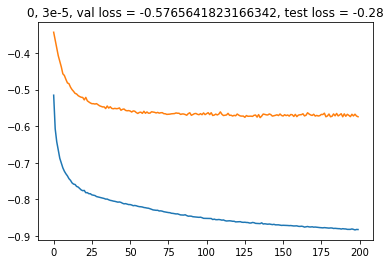

multi_reg_p1
-0.3666812236842362 -0.55 0 1e-5
-0.3561368207100425 -0.55 1 1e-5
-0.3632476433550005 -0.55 2 1e-5
-0.35832005624225083 -0.55 0 3e-5
-0.36356676402476623 -0.55 1 3e-5
-0.36080444233730236 -0.54 2 3e-5


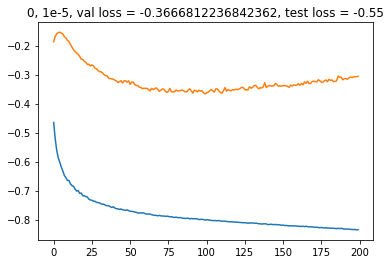

single_noreg_p0
-0.5717149240878345 -0.35 0 1e-5
-0.5726321989833556 -0.36 1 1e-5
-0.571128393970014 -0.35 2 1e-5
-0.5824964852283003 -0.31 0 3e-5
-0.5854630491631428 -0.32 1 3e-5
-0.5815985651036386 -0.31 2 3e-5


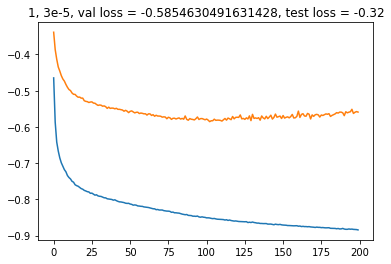

single_noreg_p1
-0.3852568125980031 -0.56 0 1e-5
-0.391475383853496 -0.55 1 1e-5
-0.38457881549123485 -0.55 2 1e-5
-0.3849898904237954 -0.56 0 3e-5
-0.38757852170296725 -0.56 1 3e-5
-0.38909045601312053 -0.56 2 3e-5


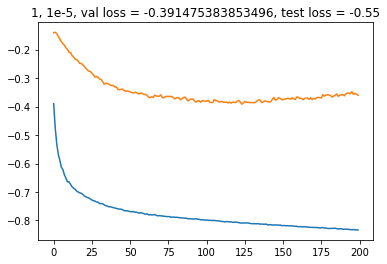

In [12]:
for c in ['multi_noreg_p0', 'multi_noreg_p1', 'multi_reg_p0', 'multi_reg_p1', 'single_noreg_p0', 'single_noreg_p1']:
    print(c)
    best = float("inf")
    for b in ["1e-5", "3e-5"]:
        for a in [0, 1, 2]:
            f = open(f"../../finetune_results_output/only/only_{c}/run{a}_{b}.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            epochs = [i for i in range(200)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            # plt.figure()
            # plt.plot(epochs, tloss)
            # plt.plot(epochs, vloss)
            # plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            # plt.show()
    plt.figure()
    plt.plot(epochs, plottloss)
    plt.plot(epochs, plotvloss)
    plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    plt.show()

multi_noreg_p0
-0.5363056663237019 -0.36 0 1e-5


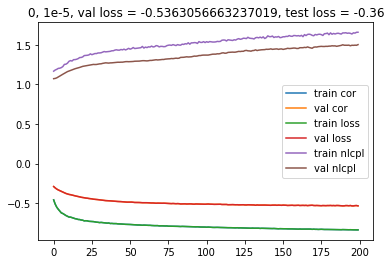

-0.5625633837607571 -0.32 0 3e-5


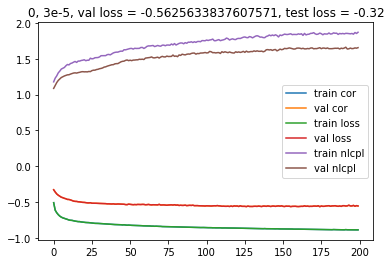

-0.5429221649055598 -0.35 1 1e-5


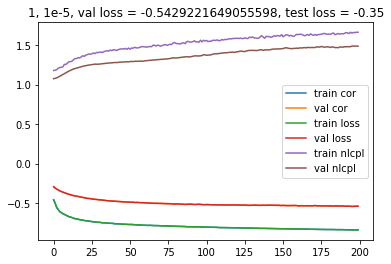

-0.5652260315070212 -0.32 1 3e-5


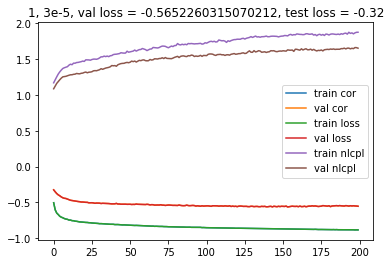

-0.5410491125232983 -0.35 2 1e-5


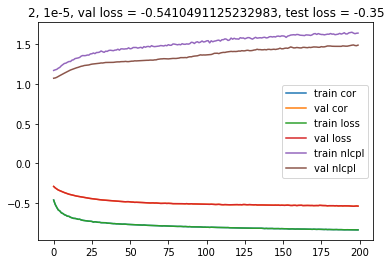

-0.563919402612272 -0.33 2 3e-5


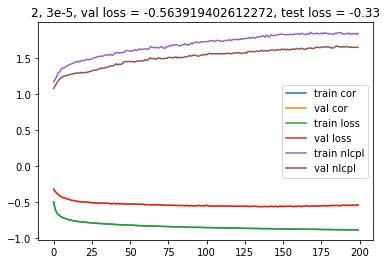

multi_noreg_p1
-0.3941038866320157 -0.5 0 1e-5


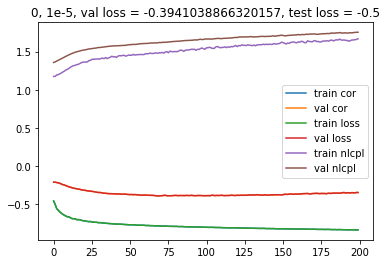

-0.3927024330130392 -0.52 0 3e-5


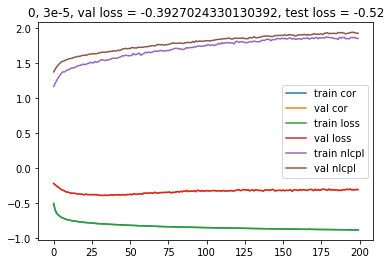

-0.39742176069663976 -0.52 1 1e-5


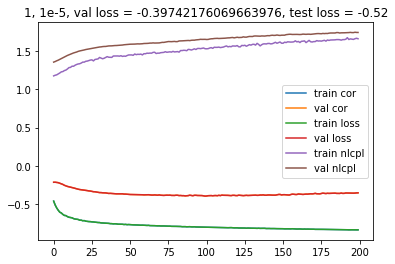

-0.39643662889550546 -0.52 1 3e-5


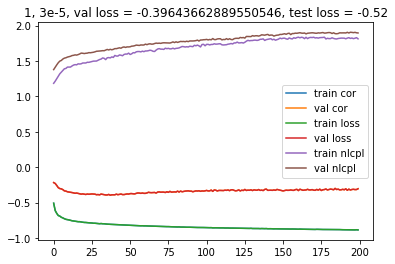

-0.3873468903815592 -0.52 2 1e-5


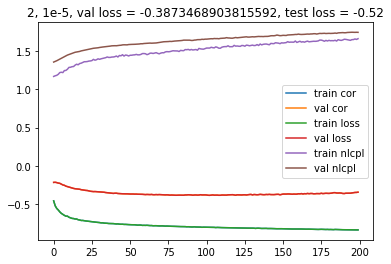

-0.3903158199185299 -0.52 2 3e-5


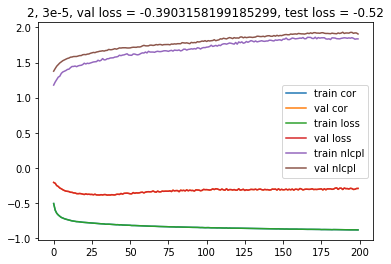

In [11]:
for c in ['multi_noreg_p0', 'multi_noreg_p1']:
    print(c)
    best = float("inf")
    for a in [0, 1, 2]:
        for b in ["1e-5", "3e-5"]:
            f = open(f"../../finetune_results_output/only/only_{c}/run{a}_{b}.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            fulltloss = [x[0] for x in d['train_loss']]
            fullvloss = [x[0] for x in d['val_loss']]
            tnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['train_loss']]
            vnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['val_loss']]
            epochs = [i for i in range(200)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            plt.figure()
            plt.plot(epochs, tloss)
            plt.plot(epochs, vloss)
            plt.plot(epochs, fulltloss)
            plt.plot(epochs, fullvloss)
            plt.plot(epochs, tnlcpl)
            plt.plot(epochs, vnlcpl)
            plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            plt.legend(["train cor", "val cor", "train loss", "val loss", "train nlcpl", "val nlcpl"])
            plt.show()
    # plt.figure()
    # plt.plot(epochs, plottloss)
    # plt.plot(epochs, plotvloss)
    # plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    # plt.show()

multi_noreg_p1
-0.3927024330130392 -0.52 0 3e-5
-0.39643662889550546 -0.52 1 3e-5
-0.3903158199185299 -0.52 2 3e-5


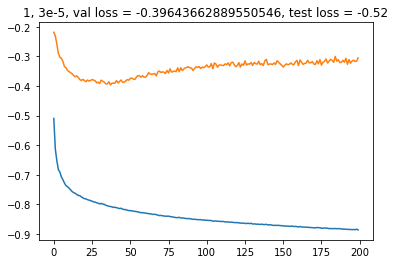

multi_reg_p1
-0.35832005624225083 -0.55 0 3e-5
-0.36356676402476623 -0.55 1 3e-5
-0.36080444233730236 -0.54 2 3e-5


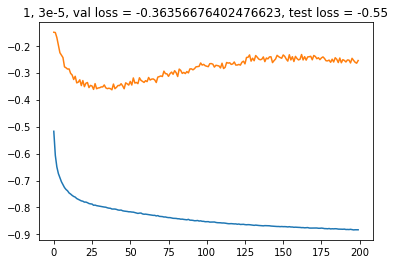

single_noreg_p1
-0.3849898904237954 -0.56 0 3e-5
-0.38757852170296725 -0.56 1 3e-5
-0.38909045601312053 -0.56 2 3e-5


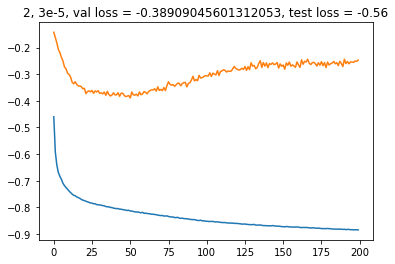

single_reg_p1
-0.29888715912889363 -0.52 0 3e-5
-0.30065953474114676 -0.52 1 3e-5
-0.2963814237539451 -0.52 2 3e-5


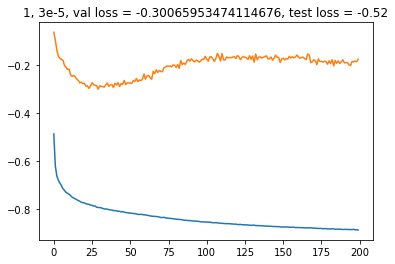

term_multi_noreg_p1
-0.3382210172739296 -0.54 0 3e-5
-0.3264682441766162 -0.54 1 3e-5
-0.3335140195746078 -0.54 2 3e-5


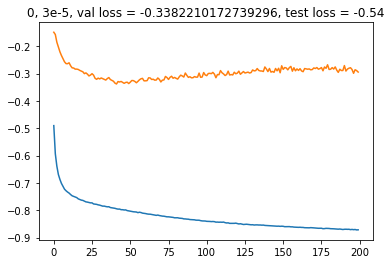

term_single_noreg_p1
-0.33903959749551993 -0.54 0 3e-5
-0.33639938414310666 -0.54 1 3e-5
-0.3332540474747699 -0.54 2 3e-5


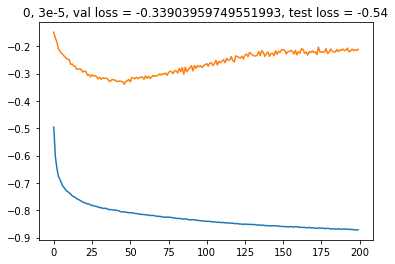

single_reg_p1
-0.29888715912889363 -0.52 0 3e-5
-0.30065953474114676 -0.52 1 3e-5
-0.2963814237539451 -0.52 2 3e-5


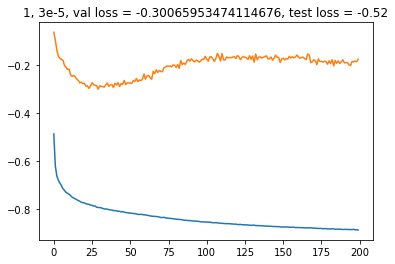

In [4]:
for c in ['multi_noreg_p1', 'multi_reg_p1', 'single_noreg_p1', 'single_reg_p1', 'term_multi_noreg_p1', 'term_single_noreg_p1', 'single_reg_p1']:
    print(c)
    best = float("inf")
    for b in ["3e-5"]:
        for a in [0, 1, 2]:
            f = open(f"../../tuning/only_{c}/run{a}_{b}/train-output_run0.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            epochs = [i for i in range(200)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            # plt.figure()
            # plt.plot(epochs, tloss)
            # plt.plot(epochs, vloss)
            # plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            # plt.show()
    plt.figure()
    plt.plot(epochs, plottloss)
    plt.plot(epochs, plotvloss)
    plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    plt.show()

terms
-0.33816391939300294 -0.54 0 3e-5


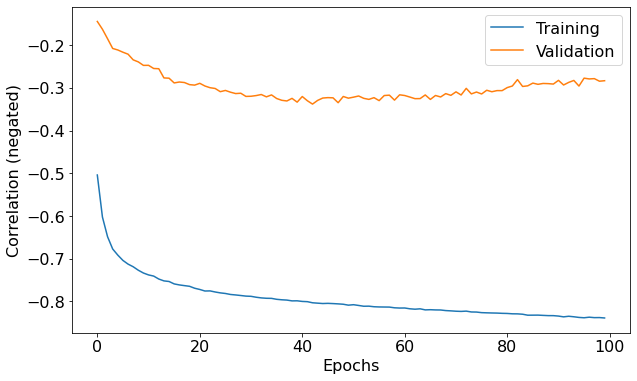

-0.40568110000943236 -0.56 1 3e-5


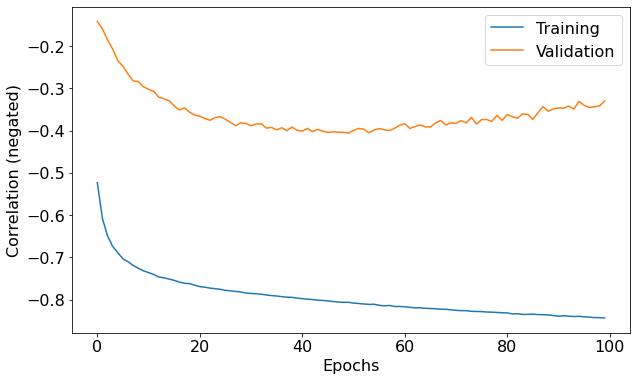

-0.33939642133208064 -0.55 2 3e-5


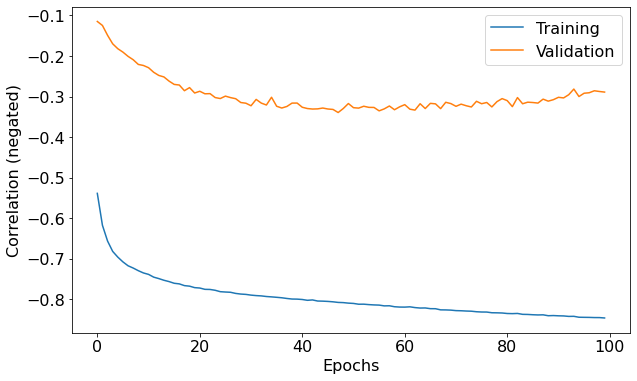

In [10]:
for c in ['terms']:
    print(c)
    best = float("inf")
    for b in ["3e-5"]:
        vallosses = []
        for a in [0, 1, 2]:
            f = open(f"../../tuning/triplicate/{c}/run{a}_{b}/train-output_run0.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            fulltloss = [x[0] for x in d['train_loss']]
            fullvloss = [x[0] for x in d['val_loss']]
            tnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['train_loss']]
            vnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['val_loss']]
            epochs = [i for i in range(100)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)
            vallosses.append(valloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            plt.rcParams.update({'font.size': 16})
            plt.figure(figsize=(10,6))
            plt.plot(epochs, tloss)
            plt.plot(epochs, vloss)
#             plt.plot(epochs, fulltloss)
#             plt.plot(epochs, fullvloss)
#             plt.plot(epochs, tnlcpl)
#             plt.plot(epochs, vnlcpl)
#             plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
#             plt.legend(["train cor", "val cor", "train loss", "val loss", "train nlcpl", "val nlcpl"])
            plt.legend(["Training", "Validation"])
            plt.xlabel("Epochs")
            plt.ylabel("Correlation (negated)")
            plt.show()
            # plt.figure()
            # plt.plot(epochs, tloss)
            # plt.plot(epochs, vloss)
            # plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            # plt.show()
#         print(np.mean(vallosses))
#         print(np.std(vallosses))
#     plt.figure()
#     plt.plot(epochs, plottloss)
#     plt.plot(epochs, plotvloss)
#     plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
#     plt.show()

coordm
-0.27715128236552056 -0.5 0 3e-5


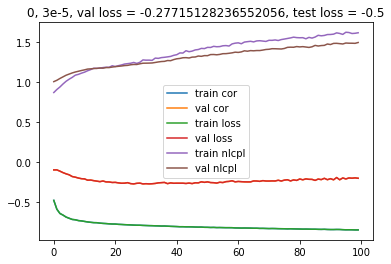

-0.27166673254833484 -0.54 1 3e-5


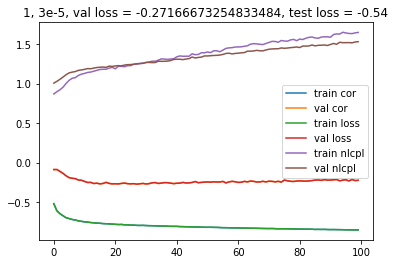

-0.2742908523821225 -0.55 2 3e-5


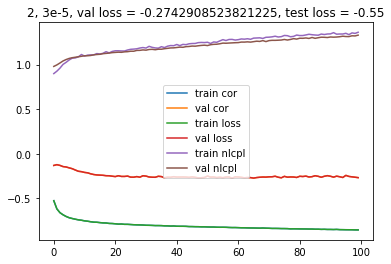

-0.27436962243199264
0.002239750762155672


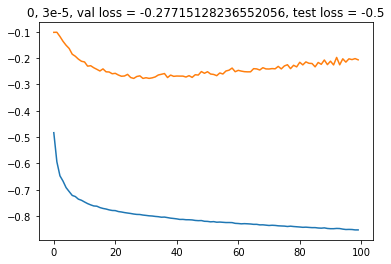

In [18]:
for c in ['coordm']:
    print(c)
    best = float("inf")
    for b in ["3e-5"]:
        vallosses = []
        for a in [0, 1, 2]:
            f = open(f"../../tuning/triplicate/{c}/run{a}_{b}/train-output_run0.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            fulltloss = [x[0] for x in d['train_loss']]
            fullvloss = [x[0] for x in d['val_loss']]
            tnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['train_loss']]
            vnlcpl = [x[1]['nlcpl']['loss']/3 for x in d['val_loss']]
            epochs = [i for i in range(100)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)
            vallosses.append(valloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            plt.figure()
            plt.plot(epochs, tloss)
            plt.plot(epochs, vloss)
            plt.plot(epochs, fulltloss)
            plt.plot(epochs, fullvloss)
            plt.plot(epochs, tnlcpl)
            plt.plot(epochs, vnlcpl)
            plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            plt.legend(["train cor", "val cor", "train loss", "val loss", "train nlcpl", "val nlcpl"])
            plt.show()
            # plt.figure()
            # plt.plot(epochs, tloss)
            # plt.plot(epochs, vloss)
            # plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            # plt.show()
        print(np.mean(vallosses))
        print(np.std(vallosses))
    plt.figure()
    plt.plot(epochs, plottloss)
    plt.plot(epochs, plotvloss)
    plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    plt.show()

coordm
-0.2108203063244217 -0.49 0 1
-0.23693533946289888 -0.54 1 1
-0.23048848499605137 -0.49 2 1
-0.22608137692779065
0.011107525680064453
-0.21489806117224322 -0.47 0 10
-0.2564294312702739 -0.53 1 10
-0.25041359663038854 -0.48 2 10
-0.24058036302430189
0.018325447478280087
-0.25847273768866286 -0.49 0 100
-0.25196666685140745 -0.51 1 100
-0.26667349990985256 -0.53 2 100
-0.25903763481664094
0.006017312037011317
-0.2717616327058641 -0.52 0 1000
-0.2723926548496739 -0.53 1 1000
-0.2709252893000141 -0.54 2 1000
-0.271693192285184
0.000601001099538242


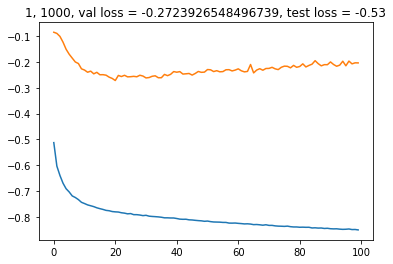

In [17]:
for c in ['coordm']:
    print(c)
    best = float("inf")
    for b in [1, 10, 100, 1000]:
        vallosses = []
        for a in [0, 1, 2]:
            f = open(f"../../tuning/include_nlcpl/{c}/run{a}_{b}/train-output_run0.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            fulltloss = [x[0]/b for x in d['train_loss']]
            fullvloss = [x[0]/b for x in d['val_loss']]
            tnlcpl = [x[1]['nlcpl']['loss']/6 for x in d['train_loss']]
            vnlcpl = [x[1]['nlcpl']['loss']/6 for x in d['val_loss']]
            epochs = [i for i in range(100)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)
            vallosses.append(valloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b
            
            print(valloss, testloss, a, b)

        print(np.mean(vallosses))
        print(np.std(vallosses))
    plt.figure()
    plt.plot(epochs, plottloss)
    plt.plot(epochs, plotvloss)
    plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    plt.show()

coordm
-0.2108203063244217 -0.49 0 1


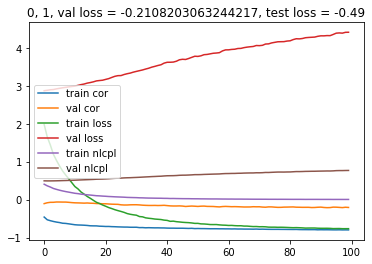

-0.23693533946289888 -0.54 1 1


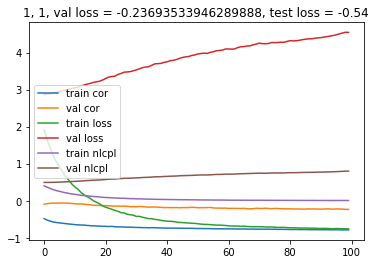

-0.23048848499605137 -0.49 2 1


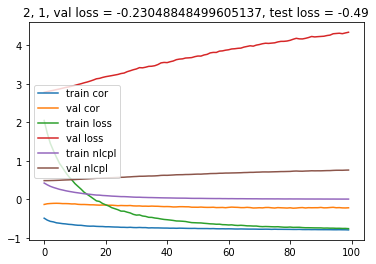

-0.22608137692779065
0.011107525680064453
-0.21489806117224322 -0.47 0 10


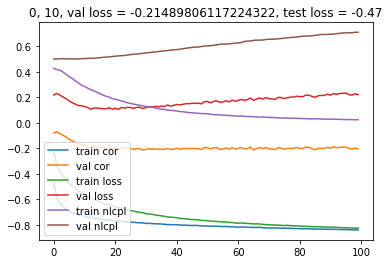

-0.2564294312702739 -0.53 1 10


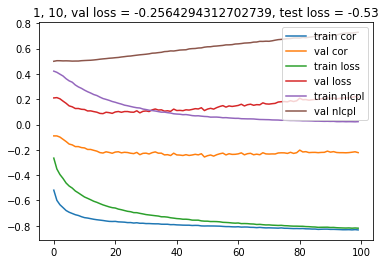

-0.25041359663038854 -0.48 2 10


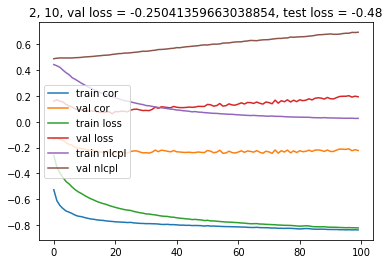

-0.24058036302430189
0.018325447478280087
-0.25847273768866286 -0.49 0 100


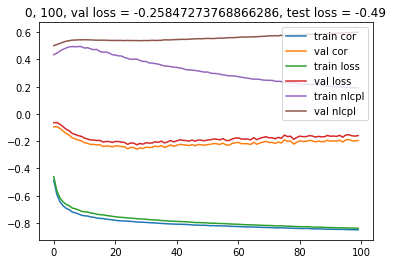

-0.25196666685140745 -0.51 1 100


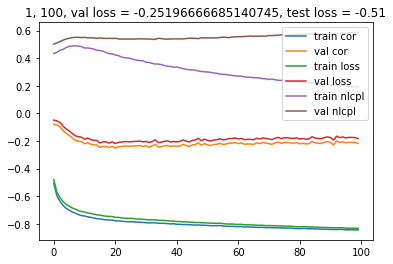

-0.26667349990985256 -0.53 2 100


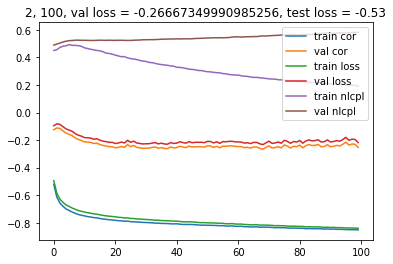

-0.25903763481664094
0.006017312037011317
-0.2717616327058641 -0.52 0 1000


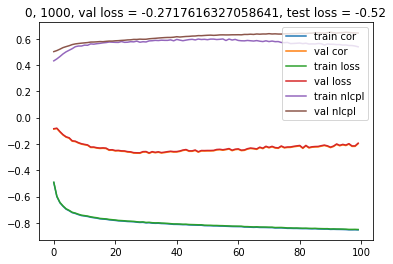

-0.2723926548496739 -0.53 1 1000


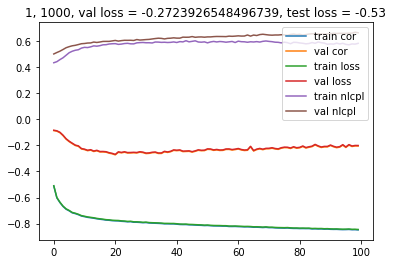

-0.2709252893000141 -0.54 2 1000


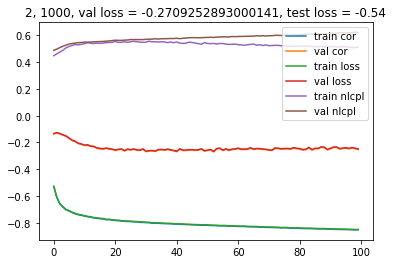

-0.271693192285184
0.000601001099538242


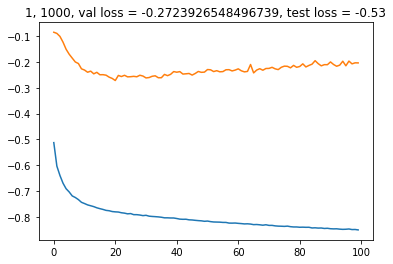

In [16]:
for c in ['coordm']:
    print(c)
    best = float("inf")
    for b in [1, 10, 100, 1000]:
        vallosses = []
        for a in [0, 1, 2]:
            f = open(f"../../tuning/include_nlcpl/{c}/run{a}_{b}/train-output_run0.out", "r")
            l = f.readlines()
            try:
                d = eval(l[-2])
            except:
                print(a,b, "broken")
                continue
            tloss = [x[1]['sortcery_loss']['loss'] for x in d['train_loss']]
            vloss = [x[1]['sortcery_loss']['loss'] for x in d['val_loss']]
            fulltloss = [x[0]/b for x in d['train_loss']]
            fullvloss = [x[0]/b for x in d['val_loss']]
            tnlcpl = [x[1]['nlcpl']['loss']/6 for x in d['train_loss']]
            vnlcpl = [x[1]['nlcpl']['loss']/6 for x in d['val_loss']]
            epochs = [i for i in range(100)]

            testloss = round(eval(l[-1].split("dict ")[1])['sortcery_loss']['loss'], 2)
            valloss = min(vloss)
            vallosses.append(valloss)

            if valloss < best:
                best = valloss
                plotvalloss = valloss
                plottestloss = testloss
                plotepochs = epochs
                plottloss = tloss
                plotvloss = vloss
                besta = a
                bestb = b

            print(valloss, testloss, a, b)
            plt.figure()
            plt.plot(epochs, tloss)
            plt.plot(epochs, vloss)
            plt.plot(epochs, fulltloss)
            plt.plot(epochs, fullvloss)
            plt.plot(epochs, tnlcpl)
            plt.plot(epochs, vnlcpl)
            plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            plt.legend(["train cor", "val cor", "train loss", "val loss", "train nlcpl", "val nlcpl"])
            plt.show()
            # plt.figure()
            # plt.plot(epochs, tloss)
            # plt.plot(epochs, vloss)
            # plt.title(f"{a}, {b}, val loss = {valloss}, test loss = {testloss}")
            # plt.show()
        print(np.mean(vallosses))
        print(np.std(vallosses))
    plt.figure()
    plt.plot(epochs, plottloss)
    plt.plot(epochs, plotvloss)
    plt.title(f"{besta}, {bestb}, val loss = {plotvalloss}, test loss = {plottestloss}")
    plt.show()